# Unsupervised Learning (CSCA5632) Final Project 
## CDC Diabetes Health Indicators Dataset

# 1. Overview
This dataset contains healthcare statistics and lifestyle survey information about people, along with their diabetes diagnosis. It's designed to help understand the relationship between lifestyle and diabetes in the US.
From the UCI ML repository from which this data was made available, I have reorganized and adapted the following description for presentation.

I will utilize this dataset and approach it from three angles.
- Conventional supervised learning task using the features to build a model to predict the target
- Use unsupervised learning methods (such as PCA) to reduce dimensionality and then conduct supervised learning
- Use a completely unsupervised learning method to build a model to both predict the target variable and hopefully discover subgroups that explain the different subgroups within diabetic patients  

## Dataset Characteristics
- **Type**: Tabular, Multivariate
- **Subject Area**: Health and Medicine
- **Associated Tasks**: Classification
- **Feature Types**: Categorical, Integer
- **Instances**: 253,680
- **Features**: 21
- **Missing Values**: No

## Target Variable 
### (diabetes_binary)
Classification of patients into three categories:
1. Diabetes (encoded as 1)
2. Pre-diabetes (encoded as 1)
3. Healthy (encoded as 0)

## Key Features
- Demographics
- Lab test results
- Survey question responses

## Variables Table

| Variable Name        | Type    | Description                                                          |
|----------------------|---------|----------------------------------------------------------------------|
| Diabetes_binary      | Binary  | 0 = no diabetes, 1 = prediabetes or diabetes                         |
| HighBP               | Binary  | 0 = no high BP, 1 = high BP                                          |
| HighChol             | Binary  | 0 = no high cholesterol, 1 = high cholesterol                        |
| CholCheck	           | Binary  | 0 = no cholesterol check, 1 = cholesterol check in 5yrs              | 
| BMI                  | Integer | Body Mass Index                                                      |
| Smoker               | Binary  | 0 = no, 1 = yes (smoked at least 100 cigarettes in lifetime)         |
| Stroke               | Binary  | 0 = no, 1 = yes (ever told had a stroke)                             |
| HeartDiseaseorAttack | Binary  | 0 = no, 1 = yes (coronary heart disease or myocardial infarction)    |
| PhysActivity         | Binary  | 0 = no, 1 = yes (physical activity in past 30 days)                  |
| Fruits               | Binary  | 0 = no, 1 = yes (consume fruit 1 or more times per day)              |
| Veggies              | Binary  | 0 = no, 1 = yes (consume vegetables 1 or more times per day)         |
| HvyAlcoholConsump    | Binary  | 0 = no, 1 = yes (heavy drinkers based on weekly consumption)         |
| AnyHealthcare        | Binary  | 0 = no, 1 = yes (have any kind of health care coverage)              |
| NoDocbcCost	       | Binary	 | 0 = no, 1 = yes doctor visit skipped in past 12 months because cost? |
| GenHlth              | Integer | General health scale (1 = excellent to 5 = poor)                     |
| MentHlth             | Integer | Days mental health not good in past 30 days (scale 1-30)             |
| PhysHlth             | Integer | Days physical health not good in past 30 days (scale 1-30)           |
| DiffWalk             | Binary  | 0 = no, 1 = yes (serious difficulty walking or climbing stairs)      |
| Sex                  | Binary  | 0 = female, 1 = male                                                 |
| Age                  | Integer | 13-level age category (1 = 18-24, 13 = 80 or older)                  |
| Education            | Integer | Education level scale (1 = never attended, 6 = college graduate)     |
| Income               | Integer | Income scale (1 = less than $10,000, 8 = $75,000 or more)            |

## Additional Information and Related Publications
- **Source**: CDC
- **Dataset Link**: https://www.cdc.gov/brfss/annual_data/annual_2014.html
- **UCI Repository**: https://www.archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators
Incidence of End-Stage Renal Disease Attributed to Diabetes Among Persons with Diagnosed Diabetes — United States and Puerto Rico, 2000–2014
- By Nilka Rios Burrows, MPH; Israel Hora, PhD; Linda S. Geiss, MA; Edward W. Gregg, PhD; Ann Albright, PhD. 2017
- Published in Morbidity and Mortality Weekly Report
- https://www.cdc.gov/mmwr/volumes/66/wr/mm6643a2.htm

In [1]:
from typing import List

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
# Import libraries
import pandas as pd
import seaborn as sns
from lightgbm import early_stopping
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 2. Data Loading and Initial Inspection
- Load dataset using pandas
- Inspect first few rows, data types, and summary statistics
- Check for missing values and outliers
- Analyze balance of target variable

In [2]:
#from ucimlrepo import fetch_ucirepo
# fetch dataset 
# cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Define the data types for each column
dtypes = {
    'Diabetes_binary': 'bool',
    'HighBP': 'bool',
    'HighChol': 'bool',
    'CholCheck': 'bool',
    'BMI': 'int8',
    'Smoker': 'bool',
    'Stroke': 'bool',
    'HeartDiseaseorAttack': 'bool',
    'PhysActivity': 'bool',
    'Fruits': 'bool',
    'Veggies': 'bool',
    'HvyAlcoholConsump': 'bool',
    'AnyHealthcare': 'bool',
    'NoDocbcCost': 'bool',
    'GenHlth': 'category',
    'MentHlth': 'int8',
    'PhysHlth': 'int8',
    'DiffWalk': 'bool',
    'Sex': 'bool',
    'Age': 'category',
    'Education': 'category',
    'Income': 'category'
}
df_initial = pd.read_csv('data/cdc_dm.csv', dtype=dtypes)
# id is unnecessary
df_initial = df_initial.drop('ID', axis=1)
# Set order for ordinal categorical variables
ordinal_columns = {
    'GenHlth': ['1', '2', '3', '4', '5'],
    'Age': [str(i) for i in range(1, 14)],
    'Education': [str(i) for i in range(1, 7)],
    'Income': [str(i) for i in range(1, 9)]
}

for col, order in ordinal_columns.items():
    df_initial[col] = pd.Categorical(df_initial[col], categories=order, ordered=True)

In [3]:
#first few rows
df_initial.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,False,True,True,True,40,True,False,False,False,False,...,True,False,5,18,15,True,False,9,4,3
1,False,False,False,False,25,True,False,False,True,False,...,False,True,3,0,0,False,False,7,6,1
2,False,True,True,True,28,False,False,False,False,True,...,True,True,5,30,30,True,False,9,4,8
3,False,True,False,True,27,False,False,False,True,True,...,True,False,2,0,0,False,False,11,3,6
4,False,True,True,True,24,False,False,False,True,True,...,True,False,2,3,0,False,False,11,5,4


In [4]:
# variable information
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Diabetes_binary       253680 non-null  bool    
 1   HighBP                253680 non-null  bool    
 2   HighChol              253680 non-null  bool    
 3   CholCheck             253680 non-null  bool    
 4   BMI                   253680 non-null  int8    
 5   Smoker                253680 non-null  bool    
 6   Stroke                253680 non-null  bool    
 7   HeartDiseaseorAttack  253680 non-null  bool    
 8   PhysActivity          253680 non-null  bool    
 9   Fruits                253680 non-null  bool    
 10  Veggies               253680 non-null  bool    
 11  HvyAlcoholConsump     253680 non-null  bool    
 12  AnyHealthcare         253680 non-null  bool    
 13  NoDocbcCost           253680 non-null  bool    
 14  GenHlth               253680 non-nul

In [5]:
# summary statistics
df_initial.describe()

,BMI,MentHlth,PhysHlth
count,253680.000000,253680.000000,253680.000000
mean,28.382364,3.184772,4.242081
std,6.608694,7.412847,8.717951
min,12.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000
75%,31.000000,2.000000,3.000000
max,98.000000,30.000000,30.000000


Diabetes_binary
False    218334
True      35346
Name: count, dtype: int64


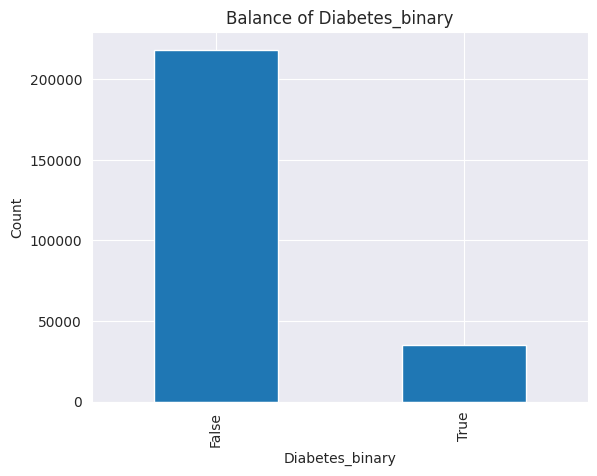

In [6]:
# Analyze balance of 'Diabetes_binary'
diabetes_balance = df_initial['Diabetes_binary'].value_counts()

# Print the counts
print(diabetes_balance)

# Plot the balance
diabetes_balance.plot(kind='bar')
plt.title('Balance of Diabetes_binary')
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.show()

## Initial Observations
- The dataset contains 253,680 rows and 21 columns.
- There are no missing values.
- The target variable 'Diabetes_binary' is imbalanced with more instances of '0'(no diabetes) than '1'(diabetes or prediabetes).
- The features have a mix of binary, integer, and categorical data types. the categorical data are all ordinal.
- The features have different scales, so scaling will be necessary for some models.


# 3. Exploratory Data Analysis (EDA)
- Univariate Analysis: Visualize individual feature distributions
- Bivariate and Multivariate Analysis: Explore relationships between variables
- Dimensionality Analysis: Evaluate need for dimensionality reduction

In [7]:
# 3.1 Univariate Analysis: Visualize individual feature distributions
def plot_univariate(df: pd.DataFrame) -> None:
    """Plots the distribution of individual features in the dataset.

    Args:
        df (pd.DataFrame): The input dataframe containing the features.
    """
    plt.figure(figsize=(20, 15))

    # Plot boolean features
    bool_cols: List[str] = df.select_dtypes(include=['bool']).columns.tolist()
    for i, col in enumerate(bool_cols, 1):
        plt.subplot(4, 4, i)
        sns.countplot(x=col, data=df)
        plt.title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

    # Plot categorical features
    cat_cols: List[str] = df.select_dtypes(include=['category']).columns.tolist()
    for i, col in enumerate(cat_cols, 1):
        plt.subplot(2, 2, i)
        sns.countplot(x=col, data=df)
        plt.title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

    # Plot numeric features
    num_cols: List[str] = df.select_dtypes(include=['int8', 'int64']).columns.tolist()
    for i, col in enumerate(num_cols, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[col], kde=True, bins=20)
        plt.title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()


# 3.2 Bivariate and Multivariate Analysis: Explore relationships between variables
def plot_bivariate_multivariate(df: pd.DataFrame) -> None:
    """Plots relationships between features in the dataset.

    Args:
        df (pd.DataFrame): The input dataframe containing the features.
    """
    plt.figure(figsize=(20, 15))

    # Correlation matrix for numeric variables
    num_cols: List[str] = df.select_dtypes(include=['int8', 'int64']).columns.tolist()
    corr_matrix: pd.DataFrame = df[num_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix for Numeric Features')
    plt.show()

    # Example: Pairplot for selected features
    sns.pairplot(df[num_cols])
    plt.show()

    # Example: Bivariate analysis with categorical data
    cat_cols: List[str] = df.select_dtypes(include=['category']).columns.tolist()
    for col in cat_cols:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=col, y='BMI', data=df)
        plt.title(f'BMI Distribution by {col}')
        plt.show()

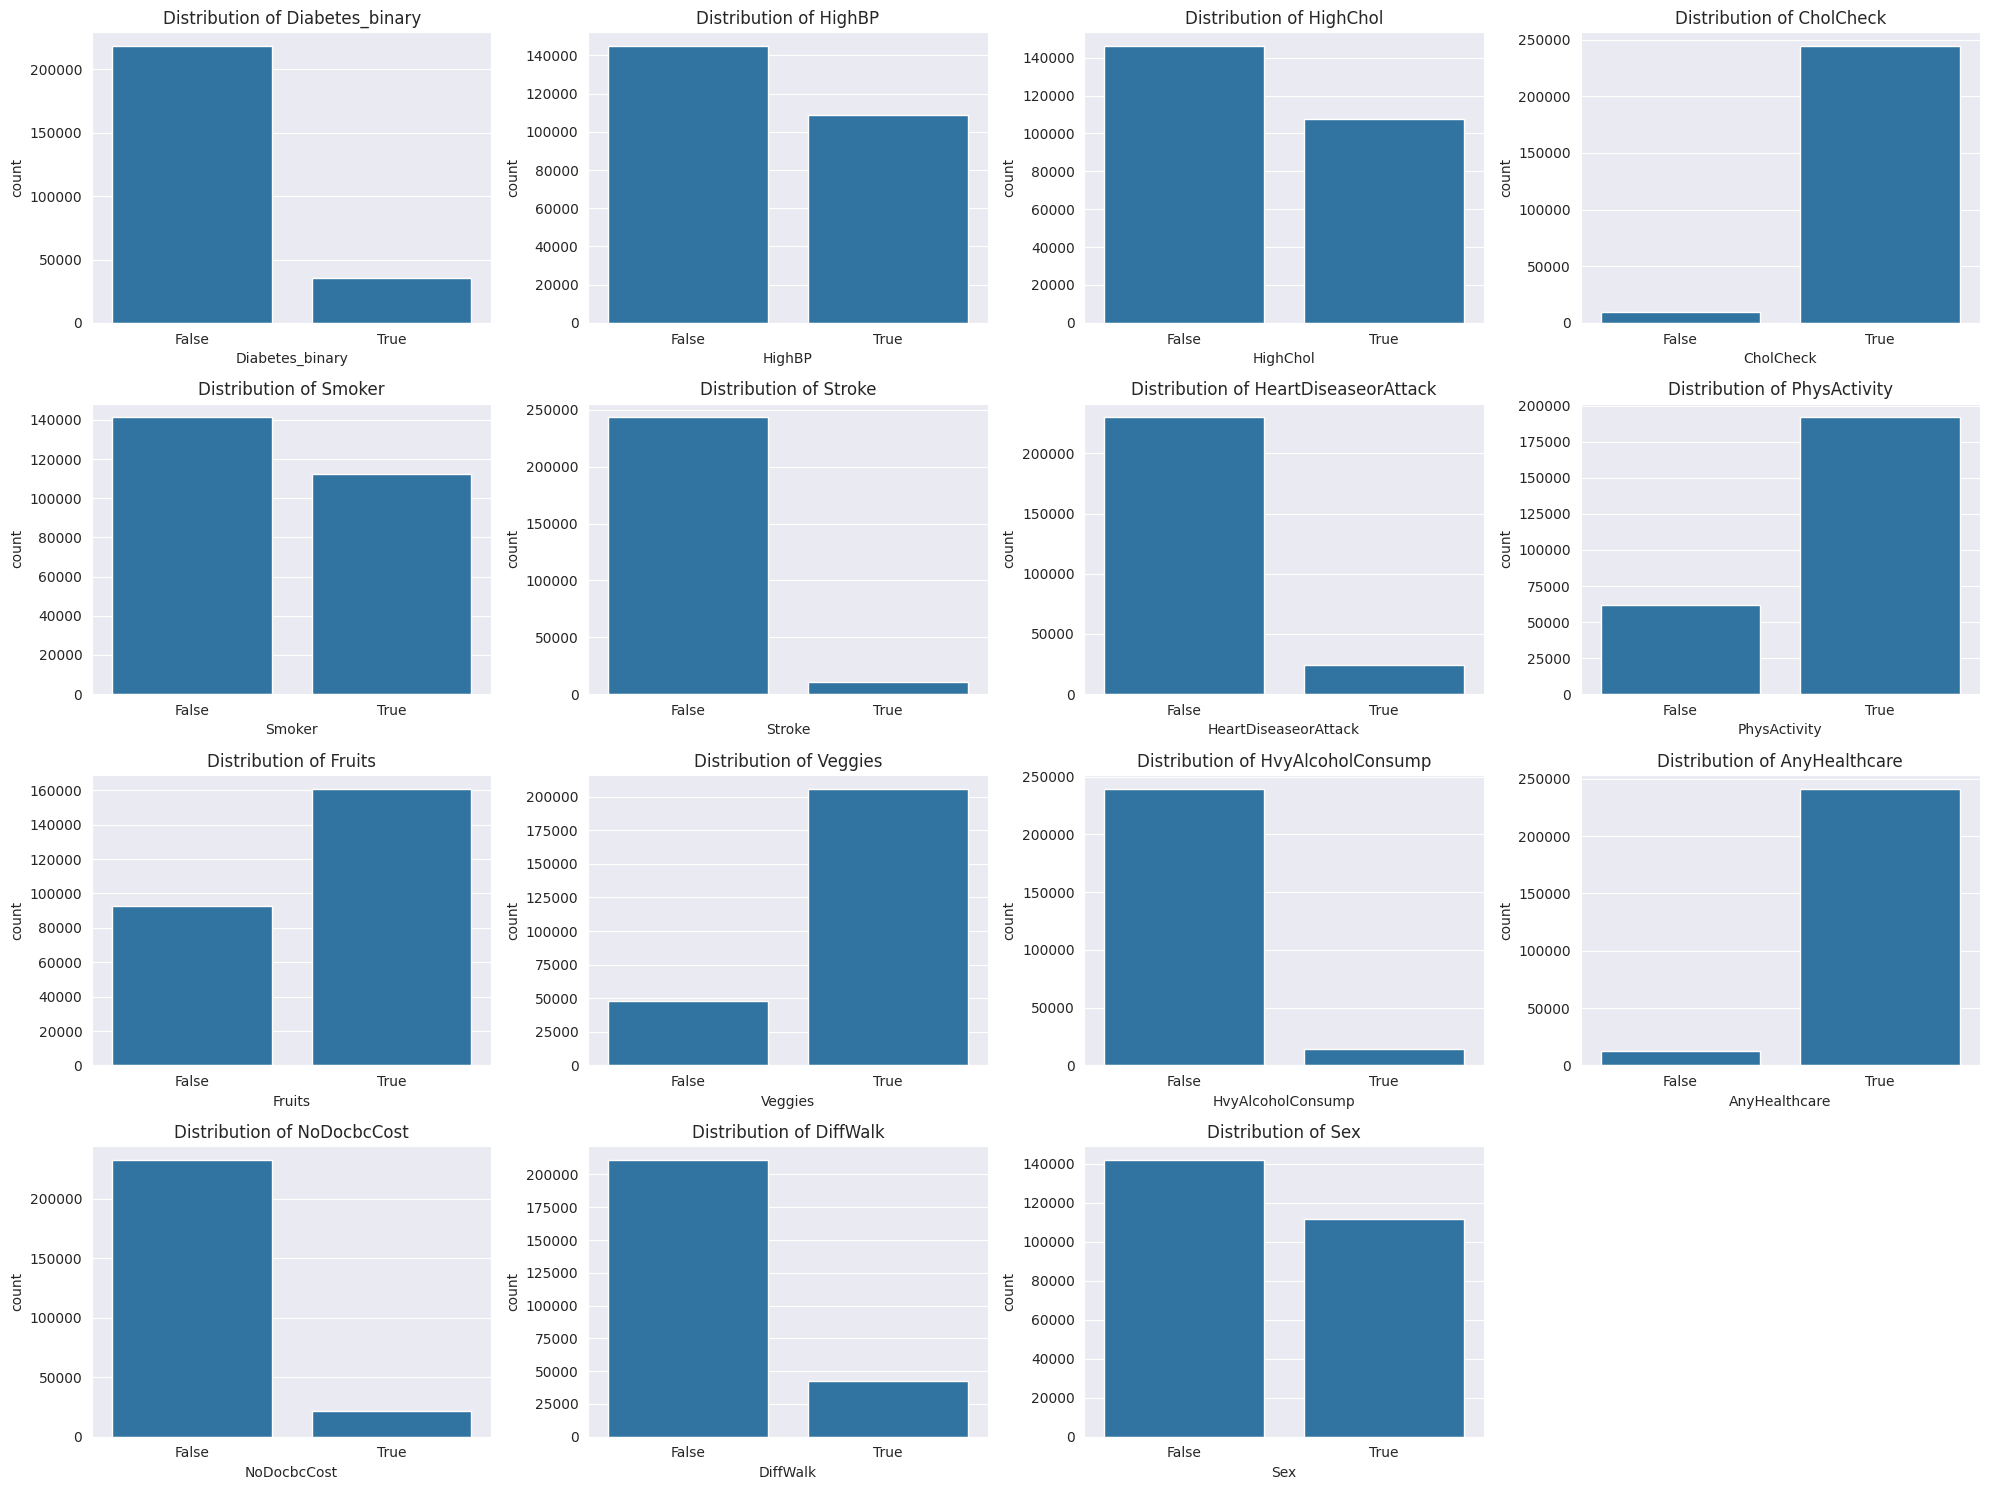

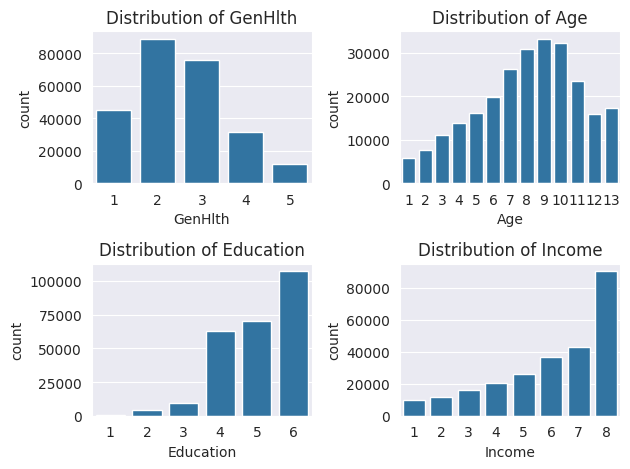

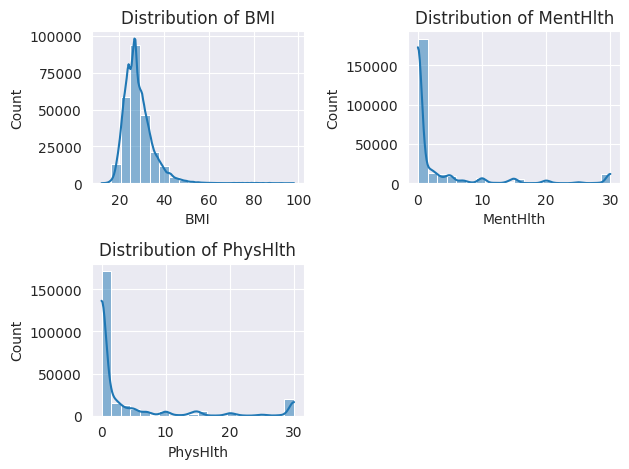

In [8]:
# Running the EDA functions on the initial dataset
# uncomment for final presentation (intensive
plot_univariate(df_initial)

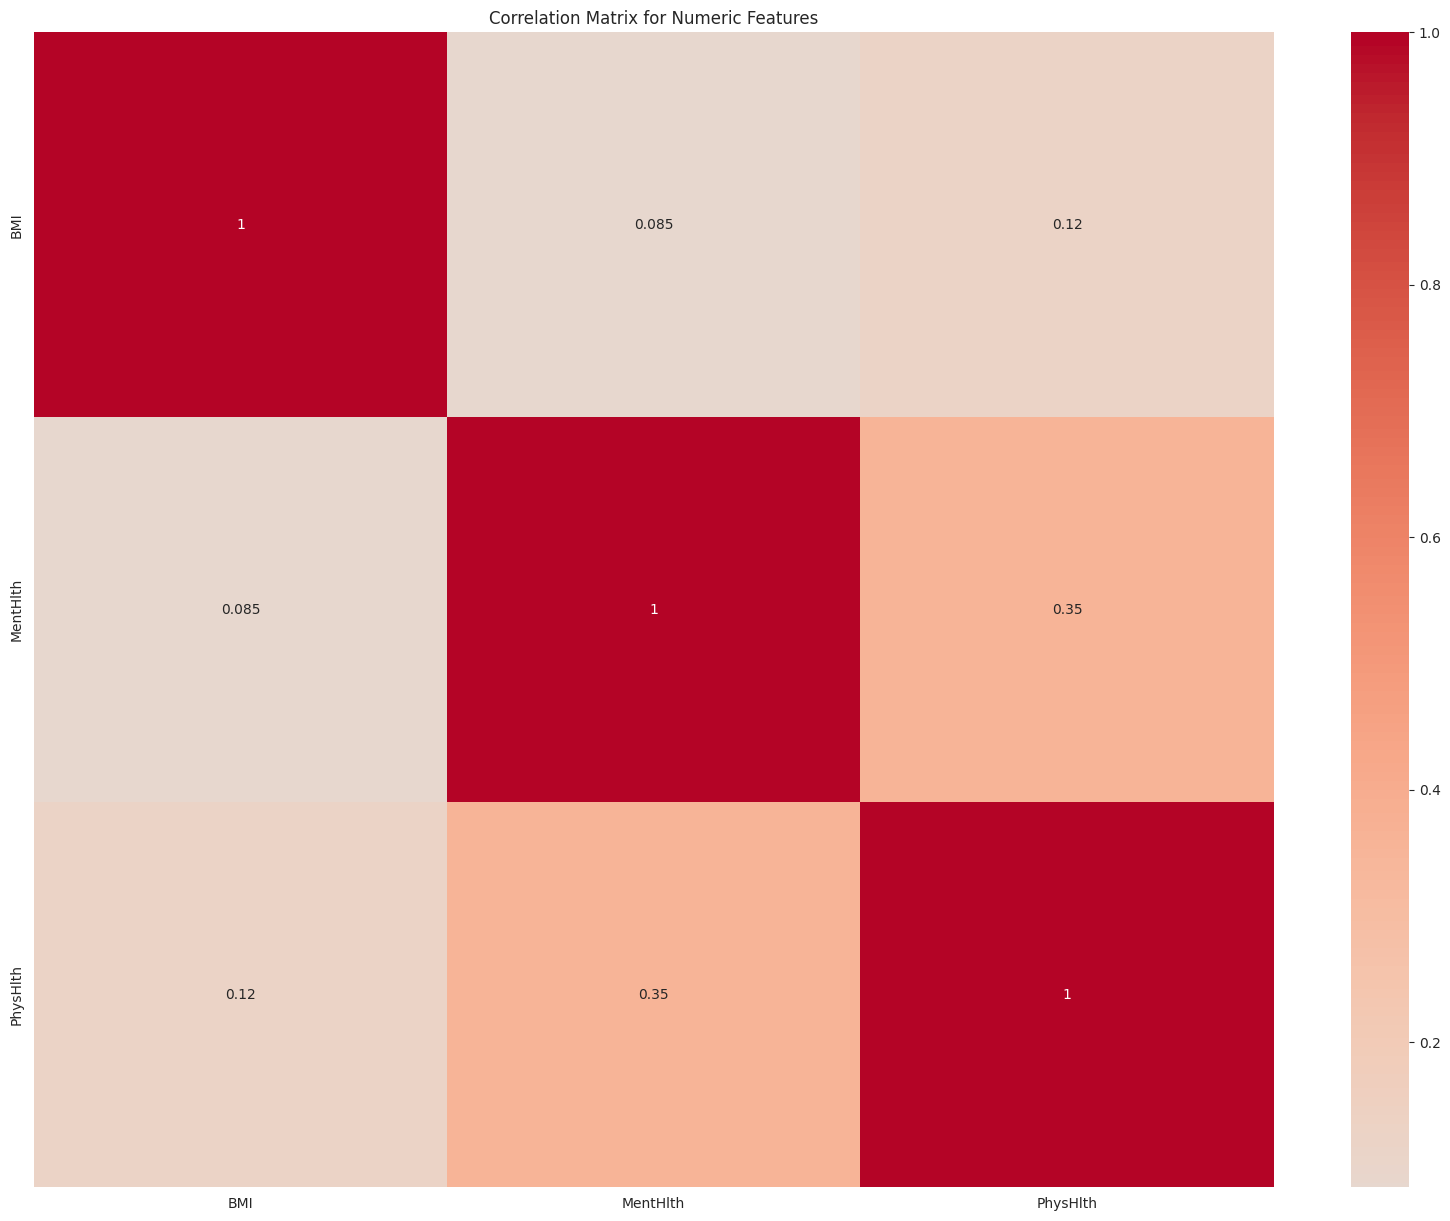

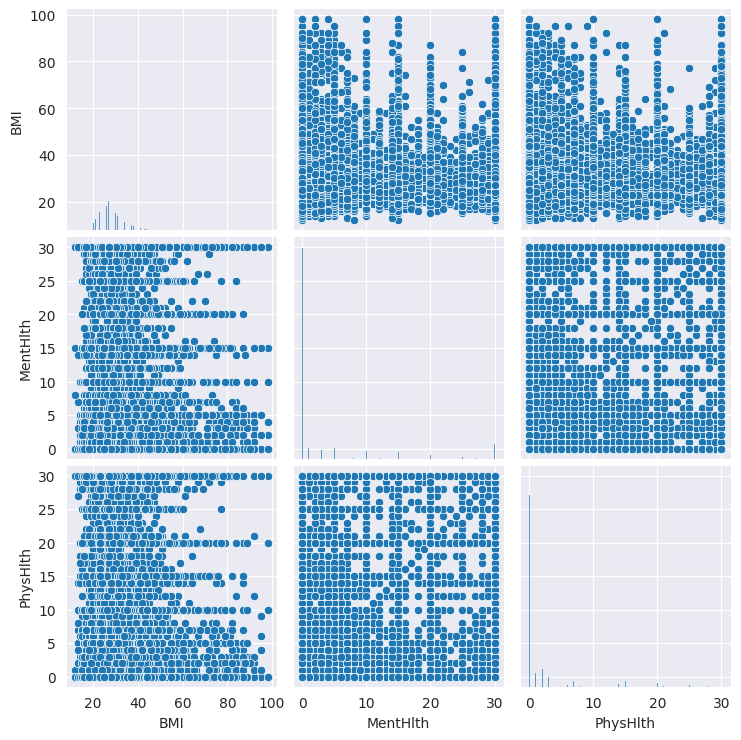

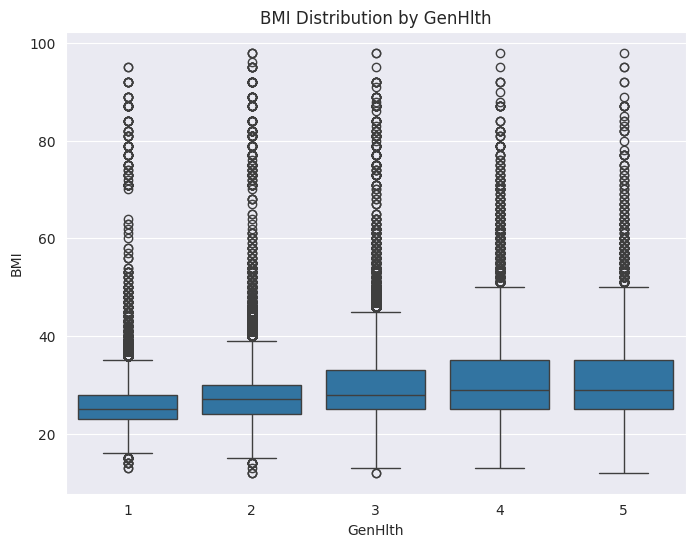

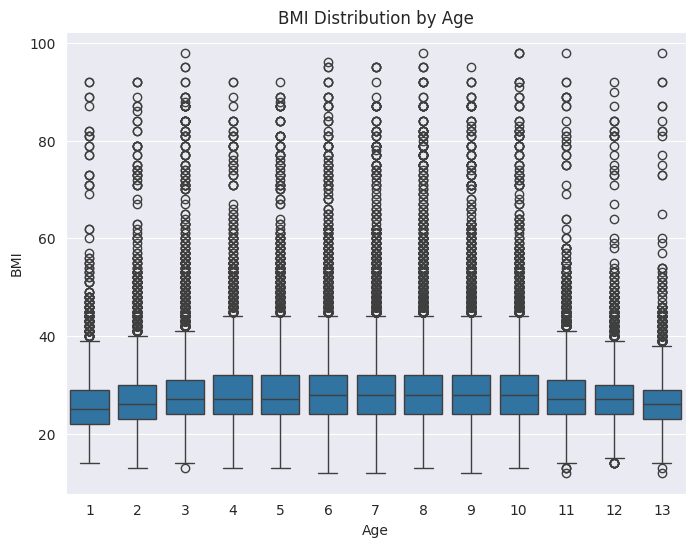

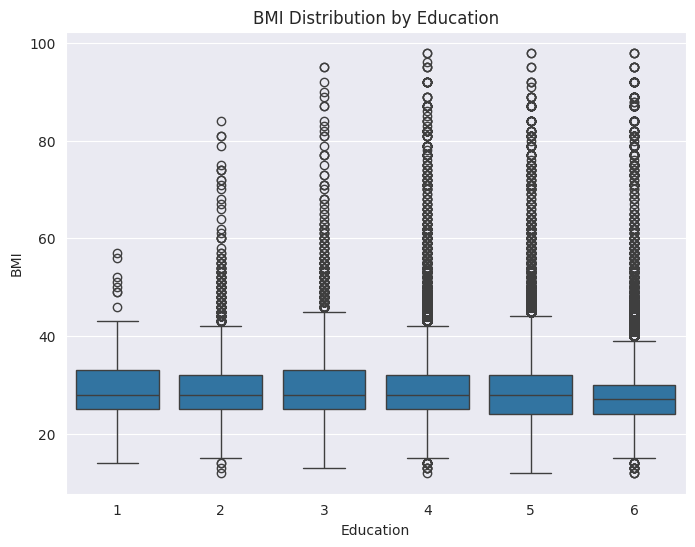

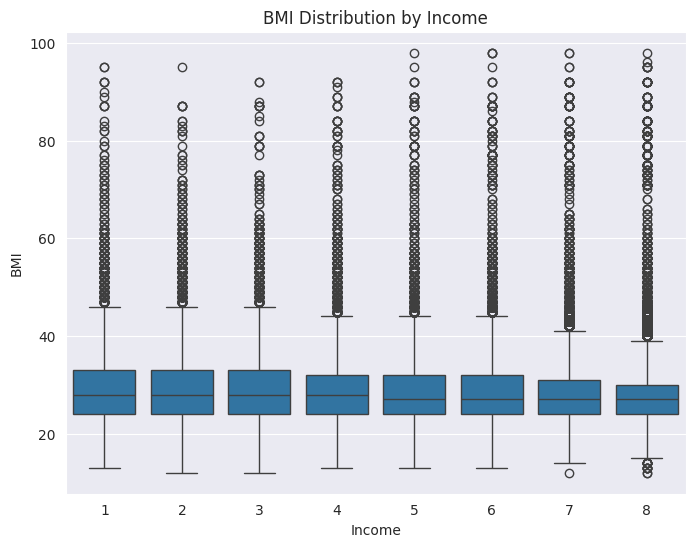

In [9]:
plot_bivariate_multivariate(df_initial)

In [10]:
def plot_univariate_with_target(df: pd.DataFrame, target: str) -> None:
    """Plots the distribution of individual features in the dataset
    against a target variable.

    Args:
        df (pd.DataFrame): The input dataframe containing the features.
        target (str): The target variable to compare against.
    """
    plt.figure(figsize=(20, 15))

    # Plot boolean features
    bool_cols: List[str] = df.select_dtypes(include=['bool']).columns.tolist()
    for i, col in enumerate(bool_cols, 1):
        plt.subplot(4, 4, i)
        sns.countplot(x=col, hue=target, data=df)
        plt.title(f'{target} vs {col}')

    plt.tight_layout()
    plt.show()

    # Plot categorical features
    cat_cols: List[str] = df.select_dtypes(include=['category']).columns.tolist()
    for i, col in enumerate(cat_cols, 1):
        plt.subplot(2, 2, i)
        sns.countplot(x=col, hue=target, data=df)
        plt.title(f'{target} vs {col}')

    plt.tight_layout()
    plt.show()

    # Plot numeric features
    num_cols: List[str] = df.select_dtypes(include=['int8', 'int64']).columns.tolist()
    for i, col in enumerate(num_cols, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df, x=col, hue=target, kde=True, bins=20, element='step')
        plt.title(f'{target} vs {col}')

    plt.tight_layout()
    plt.show()

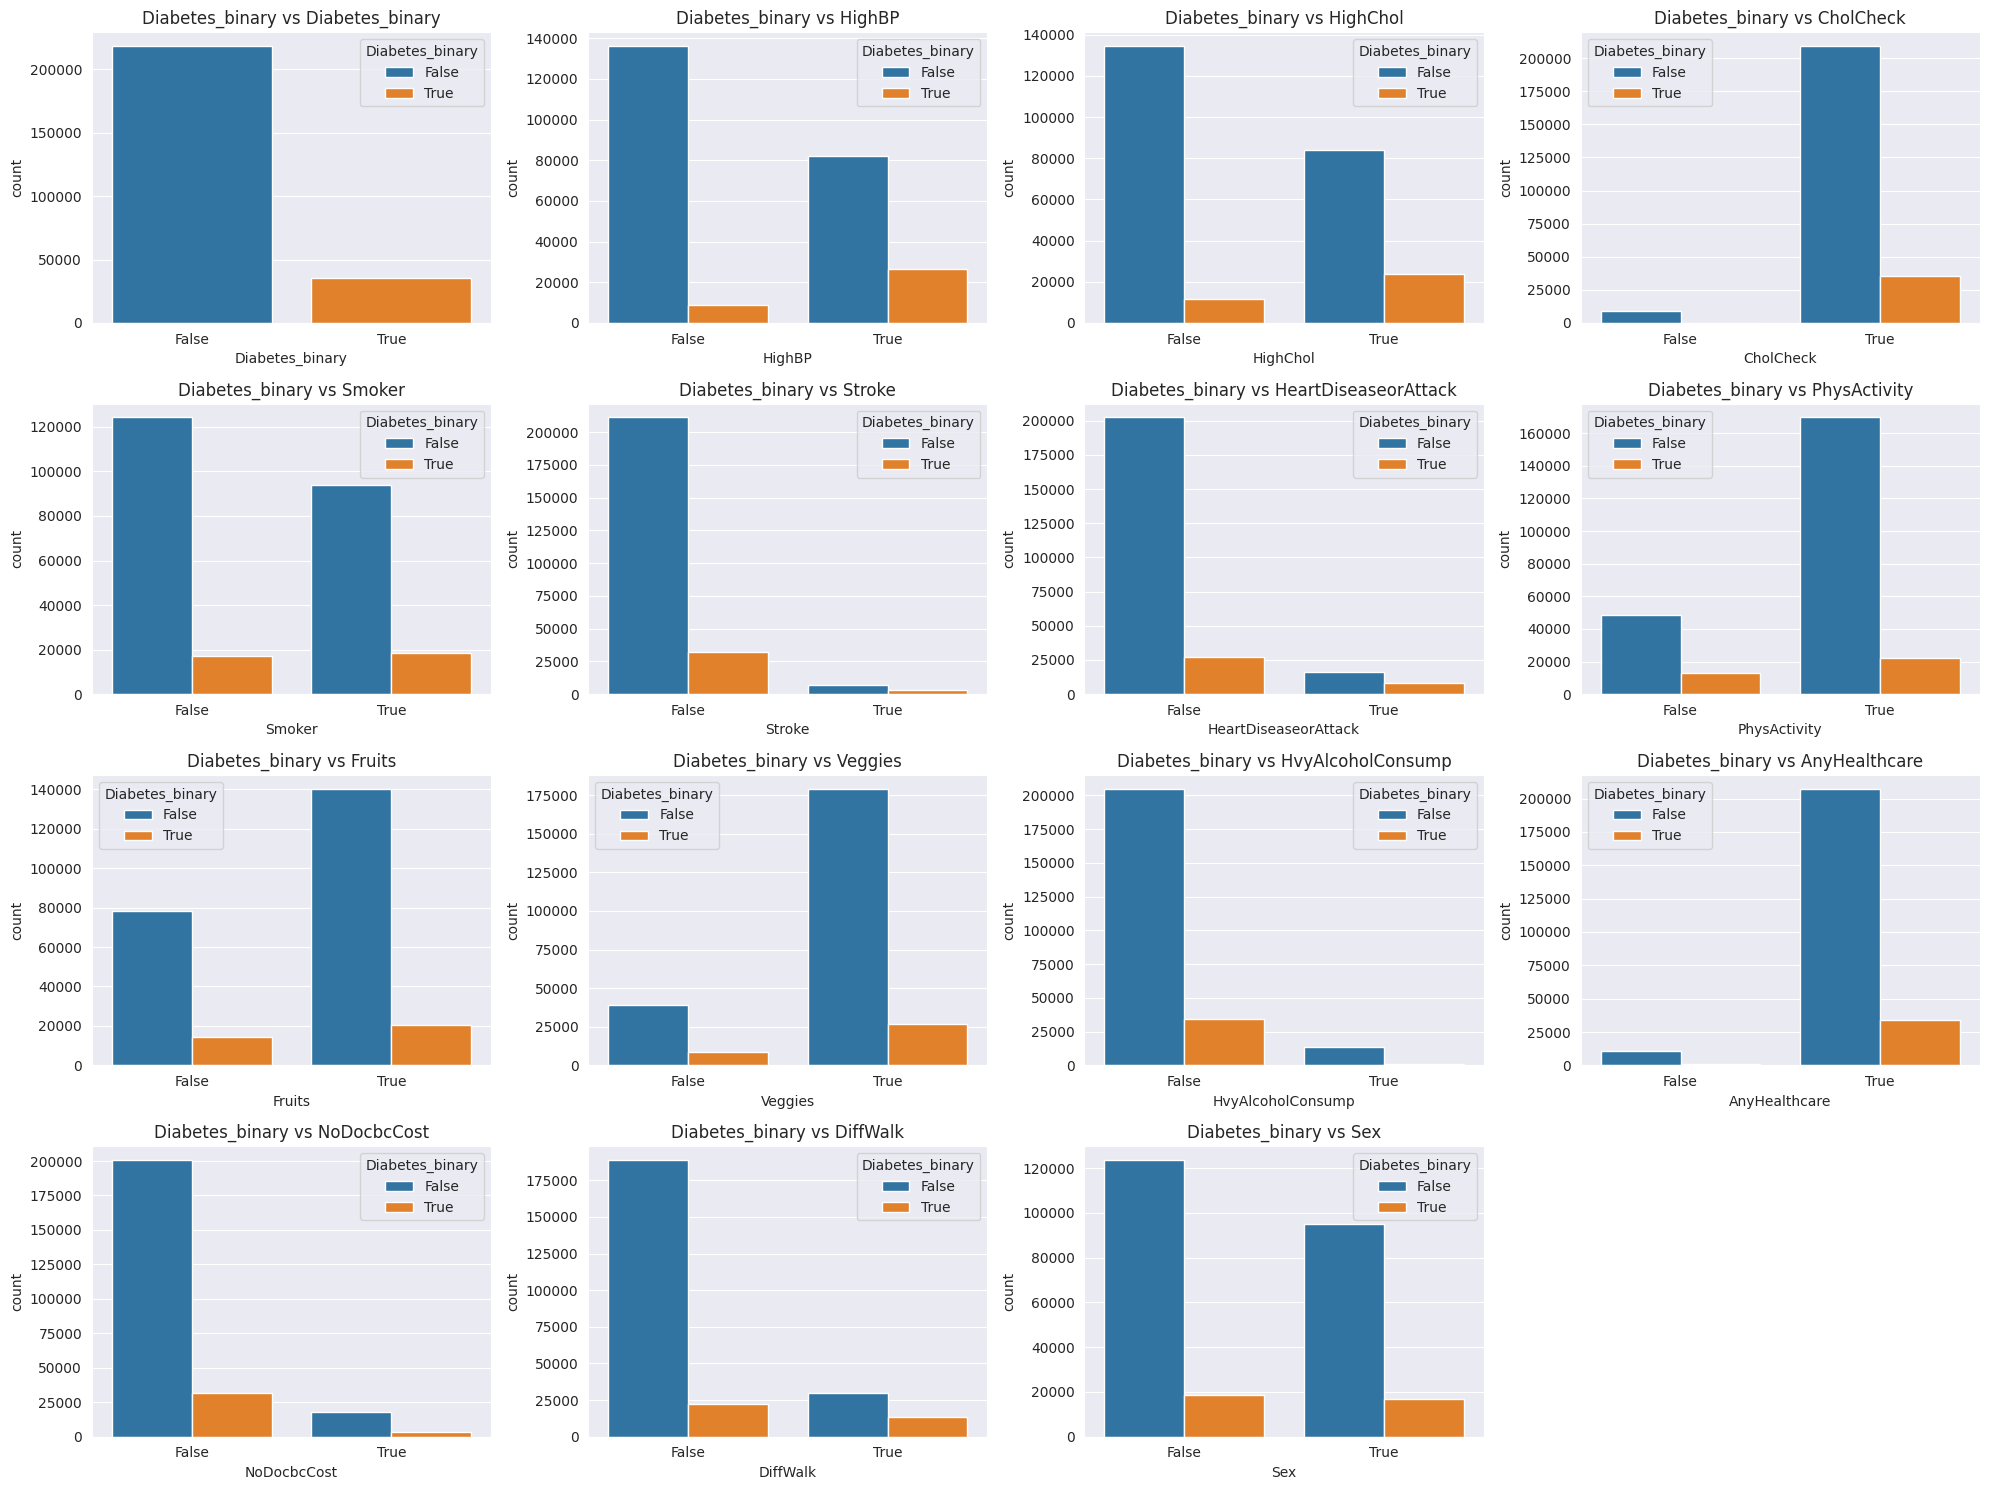

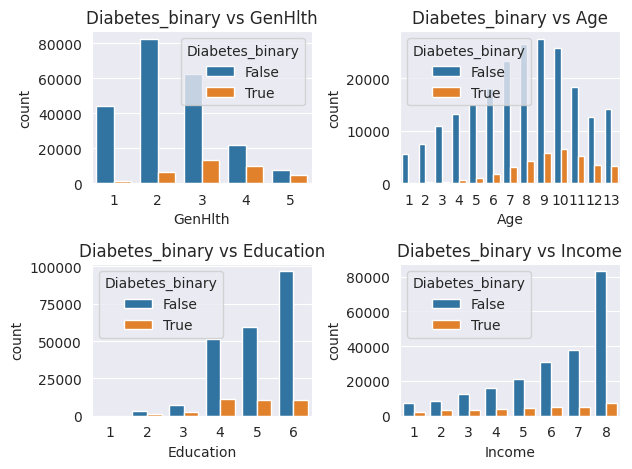

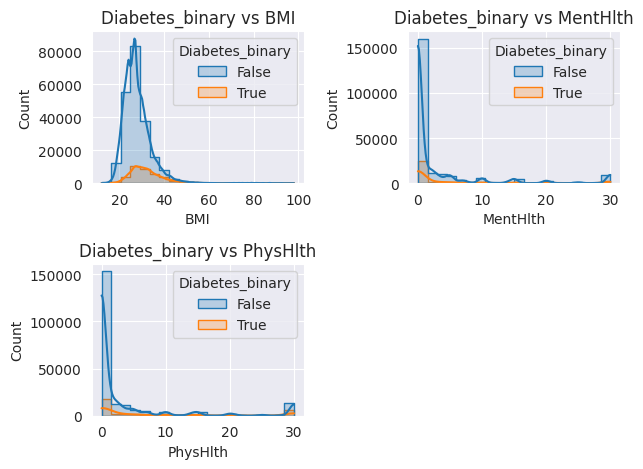

In [11]:
plot_univariate_with_target(df_initial, 'Diabetes_binary')

# 4. Data Preprocessing and Feature Engineering
- Handle missing data (if any)
  - Since we have 250k instances, drop any row with missing or NaN values
- cutoff BMI
  - 3sd from the mean
  - arbitrary 50/60/70  
- Implement dimensionality reduction techniques (PCA, t-SNE)
   - These will be used in the unsupervised + supervised learning model

In [12]:
# Ensure no missing data is present by dropping rows with any NaN values
df_clean = df_initial.dropna()
# Check the shape of the dataset after dropping rows with missing values
print(f"Shape before dropping NaNs: {df_initial.shape}")
print(f"Shape after dropping NaNs: {df_clean.shape}")

Shape before dropping NaNs: (253680, 22)
Shape after dropping NaNs: (253680, 22)


In [13]:
# BMI
# 1. Calculate 3 standard deviations from the mean for the 'BMI' column
three_sd_cutoff = df_clean['BMI'].mean() + 3 * df_clean['BMI'].std()
print(three_sd_cutoff)

48.20844621191276


In [14]:
# 2. Check the number of instances that would be excluded for cutoffs 50, 60, and 70
cutoffs = [48, three_sd_cutoff, 50, 60, 70]
for cutoff in cutoffs:
    count_above_cutoff = df_clean[df_clean['BMI'] >= cutoff].shape[0]
    print(f"Cutoff at {cutoff}: {count_above_cutoff} instances would be excluded")

Cutoff at 48: 3447 instances would be excluded
Cutoff at 48.20844621191276: 2963 instances would be excluded
Cutoff at 50: 2547 instances would be excluded
Cutoff at 60: 868 instances would be excluded
Cutoff at 70: 599 instances would be excluded


In [15]:
# 3. Filter the dataframe to remove instances with BMI >= chosen_cutoff
df_clean = df_clean[df_clean['BMI'] < 48]

## Unsupervised Learning methods for EDA
Here I use unsupervised learning methods to conduct EDA 

In [16]:
# Extract features for PCA and t-SNE (excluding target variable 'Diabetes_binary')
X = df_clean.drop(['Diabetes_binary'], axis=1)
# Standardize the data before applying PCA and t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Function to plot cumulative explained variance
def plot_cumulative_variance(pca):
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')

    # Adding horizontal lines at critical cumulative variance thresholds
    thresholds = [0.5, 0.8, 0.9, 0.95]  # 70%, 80%, 90%
    for threshold in thresholds:
        plt.axhline(y=threshold, color='r', linestyle='--', linewidth=1)
        plt.text(0.5, threshold, f'{int(threshold * 100)}% Variance', color='r', fontsize=10,
                 verticalalignment='bottom')

    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance vs. Number of Components')
    plt.xticks(range(1, len(cumsum) + 1))  # Ensure x-axis shows only integers
    plt.grid(True)
    plt.show()

In [18]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

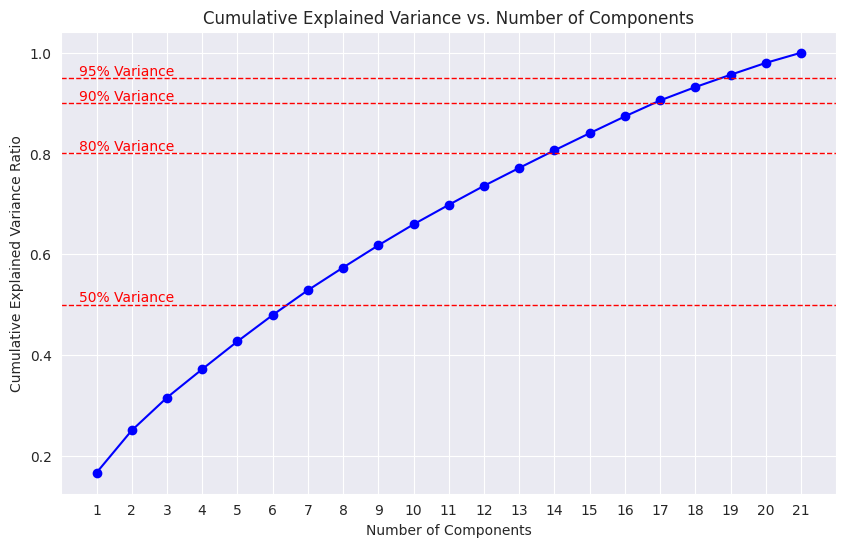

In [19]:
# Plot cumulative explained variance
plot_cumulative_variance(pca)

## Critical Thresholds for Explained Variance

- **95% Explained Variance**: 19 components
- **90% Explained Variance**: 17 components
- **80% Explained Variance**: 14 components
- **50% Explained Variance**: 7 components

In [20]:
# Function to plot PCA results
def plot_pca_results(X_pca, target, n_components):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=target, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f'PCA Results ({n_components} Components)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


# Choose optimal number of components (e.g., 95% explained variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of components for 95% explained variance: {n_components}")

# Perform PCA with optimal number of components
pca_optimal = PCA(n_components=n_components)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

Optimal number of components for 95% explained variance: 19


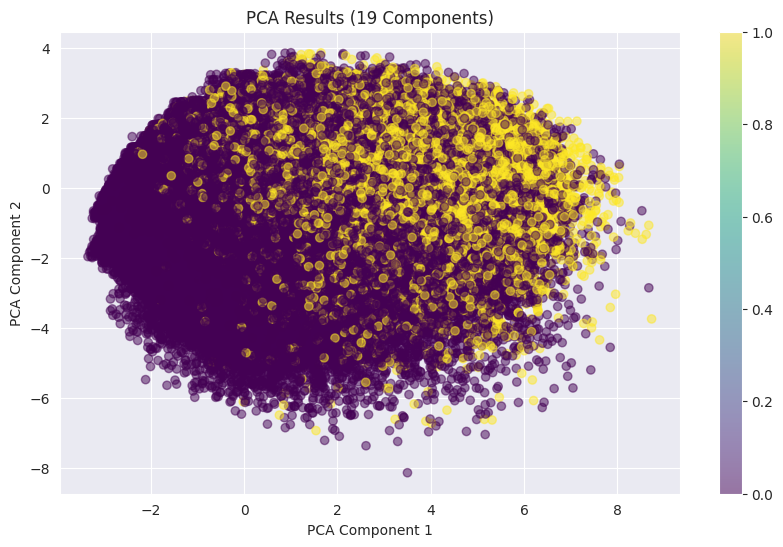

In [21]:
# Plot PCA results
plot_pca_results(X_pca_optimal, df_clean['Diabetes_binary'], n_components)

In [22]:
num_features = X.shape[1]
feature_importance = pd.DataFrame({
    'feature': X.columns[:num_features],  # Ensure correct number of features
    'importance': np.abs(pca_optimal.components_[0])  # Use first principal component
}).sort_values('importance', ascending=False)
print(f"Top 10 most important features: out of {num_features}")
print(feature_importance.head(15))

Top 10 most important features: out of 21
                 feature  importance
13               GenHlth    0.405373
16              DiffWalk    0.356017
15              PhysHlth    0.341373
20                Income    0.318727
19             Education    0.259599
0                 HighBP    0.258187
7           PhysActivity    0.235180
6   HeartDiseaseorAttack    0.221301
14              MentHlth    0.219656
1               HighChol    0.194282
18                   Age    0.180798
3                    BMI    0.173649
5                 Stroke    0.170028
4                 Smoker    0.158165
12           NoDocbcCost    0.134829


In [23]:
df_clean.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,False,True,True,True,40,True,False,False,False,False,...,True,False,5,18,15,True,False,9,4,3
1,False,False,False,False,25,True,False,False,True,False,...,False,True,3,0,0,False,False,7,6,1
2,False,True,True,True,28,False,False,False,False,True,...,True,True,5,30,30,True,False,9,4,8
3,False,True,False,True,27,False,False,False,True,True,...,True,False,2,0,0,False,False,11,3,6
4,False,True,True,True,24,False,False,False,True,True,...,True,False,2,3,0,False,False,11,5,4


In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250233 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Diabetes_binary       250233 non-null  bool    
 1   HighBP                250233 non-null  bool    
 2   HighChol              250233 non-null  bool    
 3   CholCheck             250233 non-null  bool    
 4   BMI                   250233 non-null  int8    
 5   Smoker                250233 non-null  bool    
 6   Stroke                250233 non-null  bool    
 7   HeartDiseaseorAttack  250233 non-null  bool    
 8   PhysActivity          250233 non-null  bool    
 9   Fruits                250233 non-null  bool    
 10  Veggies               250233 non-null  bool    
 11  HvyAlcoholConsump     250233 non-null  bool    
 12  AnyHealthcare         250233 non-null  bool    
 13  NoDocbcCost           250233 non-null  bool    
 14  GenHlth               250233 non-null  ca

# 5. Model Development
## 5.1 Splitting the Data
- Split the data into training (60%), validation (20%), and testing (20%) sets. We have a ton of instances so this is enough
- Ensure class balance in each set

In [25]:
# Feature, target split
X = df_clean.drop(['Diabetes_binary'], axis=1)  # Features
y = df_clean['Diabetes_binary']  # Target variable

# Step 1: Split into Test set (20%) and cross validation set (80%) 
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Split the cross validation set (80%) into Training set (75% of 80% -> 60% of total) and Validation set (25% of 80% -> 20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.25, random_state=42, stratify=y_cv)

In [26]:
# Verify split sizes
print(f"\nTrain set: {len(X_train)} ({len(X_train) / len(X):.2%})")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X):.2%})")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X):.2%})")

# Verify class balance in each set
print("\nClass balance in each set:")
print("Train set:")
print(y_train.value_counts(normalize=True))
print("\nValidation set:")
print(y_val.value_counts(normalize=True))
print("\nTest set:")
print(y_test.value_counts(normalize=True))


Train set: 150139 (60.00%)
Validation set: 50047 (20.00%)
Test set: 50047 (20.00%)

Class balance in each set:
Train set:
Diabetes_binary
False    0.863533
True     0.136467
Name: proportion, dtype: float64

Validation set:
Diabetes_binary
False    0.863528
True     0.136472
Name: proportion, dtype: float64

Test set:
Diabetes_binary
False    0.863528
True     0.136472
Name: proportion, dtype: float64


## 5.2 Supervised Model
- Train a supervised model using the training set
- We use a SOTA lightGBM model for this task

In [27]:
categorical_columns = ['GenHlth', 'Age', 'Education', 'Income']
# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_columns, reference=train_data)

# Set up the parameters
params = {
    'objective': 'binary',  # Set the learning task to binary classification.
    'boosting_type': 'gbdt',  # Use Gradient Boosting Decision Trees (GBDT) as the boosting method.
    'metric': 'binary_logloss',  # Evaluate performance using binary_logloss.
    'num_leaves': 31,  # Limit the maximum number of leaves in each tree to 31.
    'learning_rate': 0.05,  # Use a learning rate of 0.05 for gradual updates, reducing the risk of overfitting.
    'feature_fraction': 0.9,  # Randomly select 90% of features for each boosting round to prevent overfitting.
    'force_col_wise': 'true',  # Force the use of column-wise data layout for better efficiency with wide datasets.
}


In [28]:
# Train the model
model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], num_boost_round=1000)

[LightGBM] [Info] Number of positive: 20489, number of negative: 129650
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 150139, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136467 -> initscore=-1.844950
[LightGBM] [Info] Start training from score -1.844950


## 5.3 Unsupervised + Supervised Model
- Use PCA components as features in the supervised model

In [29]:
# Scaler to Standardize the data (necessary for PCA)
scaler = StandardScaler()

# Applying PCA to reduce to 10 components
pca = PCA(n_components=10)

# Pipeline for preprocessing and PCA
pipeline = Pipeline([('scaler', scaler), ('pca', pca)])

# Apply pipeline to the training data
X_train_pca = pipeline.fit_transform(X_train)
X_val_pca = pipeline.transform(X_val)
X_test_pca = pipeline.transform(X_test)

In [30]:
# Create the LightGBM dataset
train_data_pca = lgb.Dataset(X_train_pca, label=y_train)
valid_data_pca = lgb.Dataset(X_val_pca, label=y_val, reference=train_data_pca)

# Set up the parameters for LightGBM
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'force_col_wise': 'true'
}

In [31]:
# Train the USL + SL hybrid model
model_pca = lgb.train(params, train_data_pca, valid_sets=[train_data_pca, valid_data_pca], num_boost_round=1000)

[LightGBM] [Info] Number of positive: 20489, number of negative: 129650
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 150139, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136467 -> initscore=-1.844950
[LightGBM] [Info] Start training from score -1.844950


## 5.4 Unsupervised Model with clustering
- Use the training set to train a clustering model
- Since I didn't know how many clusters I was looking for I tried hierarchical clustering first

In [32]:
def plot_dendrogram(Z, max_d=None):
    plt.figure(figsize=(10, 7))
    dendrogram(Z)
    plt.title('Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    if max_d:
        plt.axhline(y=max_d, c='k', ls='--', lw=1)
    plt.show()


def find_elbow(Z, n_samples):
    last = Z[-10:, 2]
    acceleration = np.diff(last, 2)
    elbow = acceleration.argmax() + len(Z) - 10 + 1
    return elbow

In [33]:
def hierarchical_clustering(X_train, X_val, X_test, y_val=None, y_test=None, n_clusters=None, distance_threshold=None):
    """
    Perform Hierarchical Clustering on training data and evaluate results on validation and test sets.

    Parameters:
    - X_train: Features for training data.
    - X_val: Features for validation data.
    - X_test: Features for test data.
    - y_val: True labels for validation data (optional).
    - y_test: True labels for test data (optional).
    - n_clusters: Number of clusters to form (if None, determined by distance_threshold).
    - distance_threshold: The threshold to apply when forming clusters (if None, determined automatically).

    Returns:
    - labels_train: Cluster labels for training data.
    - labels_val: Cluster labels for validation data.
    - labels_test: Cluster labels for test data.
    """

    # Scale features for better clustering performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Generate the linkage matrix for dendrogram
    Z = linkage(X_train_scaled, method='ward')

    # If distance_threshold is not provided, find it using the elbow method
    if distance_threshold is None and n_clusters is None:
        elbow = find_elbow(Z, X_train.shape[0])
        distance_threshold = Z[elbow, 2]
        print(f"Automatically determined distance threshold: {distance_threshold:.2f}")

    # Plot the dendrogram
    plot_dendrogram(Z, distance_threshold)

    # Perform Hierarchical Clustering on the training data
    model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold, linkage='ward')
    labels_train = model.fit_predict(X_train_scaled)

    # Rest of the function remains the same...
    nn = NearestNeighbors(n_neighbors=1).fit(X_train_scaled)
    _, indices_val = nn.kneighbors(X_val_scaled)
    labels_val = labels_train[indices_val.flatten()]
    _, indices_test = nn.kneighbors(X_test_scaled)
    labels_test = labels_train[indices_test.flatten()]

    # Unsupervised Evaluation
    silhouette_val = silhouette_score(X_val_scaled, labels_val)
    silhouette_test = silhouette_score(X_test_scaled, labels_test)
    dbi_val = davies_bouldin_score(X_val_scaled, labels_val)
    dbi_test = davies_bouldin_score(X_test_scaled, labels_test)
    print(f'Silhouette Score (Validation): {silhouette_val:.3f}')
    print(f'Silhouette Score (Test): {silhouette_test:.3f}')
    print(f'Davies-Bouldin Index (Validation): {dbi_val:.3f}')
    print(f'Davies-Bouldin Index (Test): {dbi_test:.3f}')

    # Labelled Evaluation (if true labels are available)
    if y_val is not None and y_test is not None:
        ari_val = adjusted_rand_score(y_val, labels_val)
        ari_test = adjusted_rand_score(y_test, labels_test)
        nmi_val = normalized_mutual_info_score(y_val, labels_val)
        nmi_test = normalized_mutual_info_score(y_test, labels_test)
        print(f'Adjusted Rand Index (Validation): {ari_val:.3f}')
        print(f'Adjusted Rand Index (Test): {ari_test:.3f}')
        print(f'Normalized Mutual Information (Validation): {nmi_val:.3f}')
        print(f'Normalized Mutual Information (Test): {nmi_test:.3f}')

    return labels_train, labels_val, labels_test

In [34]:
# this turned out to be a BAD idea due to scaling O(n^2) complexity
#labels_train, labels_val, labels_test = hierarchical_clustering(X_train, X_val, X_test, y_val, y_test, n_clusters=5)


## 5.4b Trying out other more scalable USL methods

In [35]:
# Also too slow

#birch = Birch(threshold=0.5, n_clusters=10)  # Adjust threshold and n_clusters as needed
#labels_train = birch.fit_predict(X_train)
#labels_val = birch.predict(X_val)
#labels_test = birch.predict(X_test)

In [36]:
# MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans


def train_minibatch_kmeans(X_train, X_val, X_test, n_clusters=10, batch_size=1000):
    """
    Trains a MiniBatchKMeans model and predicts clusters for the training, validation, and test datasets.

    Parameters:
    - X_train: np.array or pd.DataFrame, Training data
    - X_val: np.array or pd.DataFrame, Validation data
    - X_test: np.array or pd.DataFrame, Test data
    - n_clusters: int, Number of clusters for MiniBatchKMeans
    - batch_size: int, Batch size for MiniBatchKMeans

    Returns:
    - labels_train: np.array, Cluster labels for training data
    - labels_val: np.array, Cluster labels for validation data
    - labels_test: np.array, Cluster labels for test data
    - kmeans: MiniBatchKMeans object, The trained MiniBatchKMeans model
    """

    # Initialize MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)

    # Fit the model on the training data
    labels_train = kmeans.fit_predict(X_train)

    # Predict clusters for the validation and test data
    labels_val = kmeans.predict(X_val)
    labels_test = kmeans.predict(X_test)

    return labels_train, labels_val, labels_test, kmeans

In [37]:
labels_train_mb, labels_val_mb, labels_test_mb, kmeans_mb = train_minibatch_kmeans(
    X_train, X_val, X_test, n_clusters=10, batch_size=2048
)

# 6. Model Evaluation
## 6.1a Supervised Model Performance on Validation Set

In [38]:
y_val_pred_lgbm = model.predict(X_val)
y_val_pred_lgbm_binary = [1 if prob >= 0.5 else 0 for prob in y_val_pred_lgbm]  # Convert probabilities to binary

In [39]:
# Accuracy
accuracy = accuracy_score(y_val, y_val_pred_lgbm_binary)

# F1 Score
f1 = f1_score(y_val, y_val_pred_lgbm_binary)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_lgbm_binary)

# Classification Report
class_report = classification_report(y_val, y_val_pred_lgbm_binary)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.8685
F1 Score: 0.2468
Confusion Matrix:
 [[42389   828]
 [ 5752  1078]]

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.98      0.93     43217
        True       0.57      0.16      0.25      6830

    accuracy                           0.87     50047
   macro avg       0.72      0.57      0.59     50047
weighted avg       0.84      0.87      0.84     50047



### Supervised Model Performance Summary

**Accuracy:** 0.8685  
**F1 Score:** 0.2468  

#### Confusion Matrix:
```
[[42389   828]
 [ 5752  1078]]
```

#### Classification Report:
| Class       | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| **False**   | 0.88      | 0.98   | 0.93     | 43217   |
| **True**    | 0.57      | 0.16   | 0.25     | 6830    |
| **Accuracy**|           |        | 0.87     | 50047   |
| **Macro Avg** | 0.72    | 0.57   | 0.59     | 50047   |
| **Weighted Avg** | 0.84 | 0.87   | 0.84     | 50047   |

---

### Summary
The model achieved an accuracy of 86.85%, showing strong performance in correctly identifying the majority class (False). However, the F1 Score of 0.2468 indicates poor performance in handling the minority class (True), as evidenced by the low precision and recall for this class. The weighted averages reflect this imbalance, with overall metrics being skewed towards the more prevalent class. This suggests that while the model is generally accurate, it struggles significantly with the minority class.

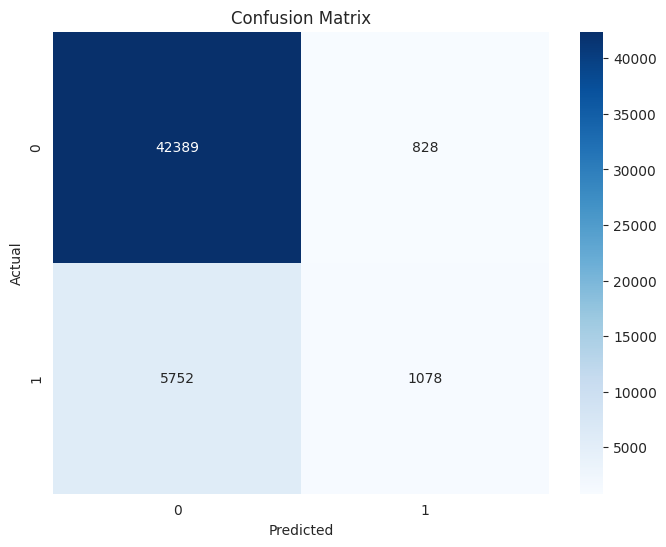

In [40]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6.1b Supervised Model Feature Importance Plot

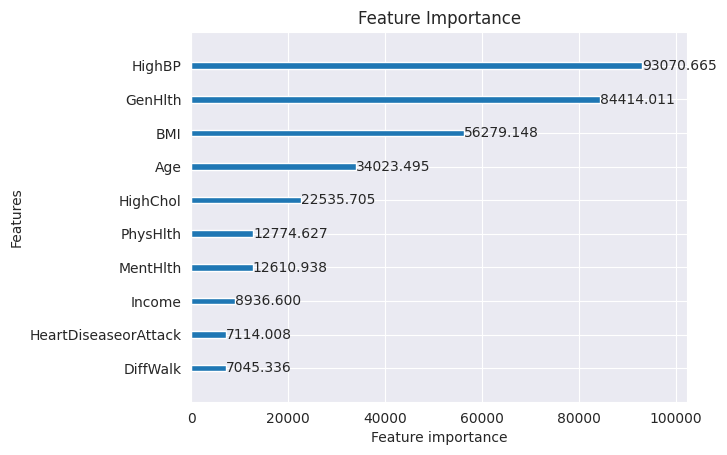

In [41]:
# Plot feature importance
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Feature Importance")
plt.show()

## 6.2 Unsupervised + Supervised Model Performance on Validation Set

In [42]:
y_val_pred_pca = model_pca.predict(X_val_pca)
y_val_pred_pca_binary = [1 if prob >= 0.5 else 0 for prob in y_val_pred_pca]

# Metrics
accuracy_pca = accuracy_score(y_val, y_val_pred_pca_binary)
f1_pca = f1_score(y_val, y_val_pred_pca_binary)
conf_matrix_pca = confusion_matrix(y_val, y_val_pred_pca_binary)
class_report_pca = classification_report(y_val, y_val_pred_pca_binary)

# Print the results
print(f"PCA Model Accuracy: {accuracy_pca:.4f}")
print(f"PCA Model F1 Score: {f1_pca:.4f}")
print("PCA Model Confusion Matrix:\n", conf_matrix_pca)
print("\nPCA Model Classification Report:\n", class_report_pca)

PCA Model Accuracy: 0.8661
PCA Model F1 Score: 0.2116
PCA Model Confusion Matrix:
 [[42448   769]
 [ 5931   899]]

PCA Model Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.98      0.93     43217
        True       0.54      0.13      0.21      6830

    accuracy                           0.87     50047
   macro avg       0.71      0.56      0.57     50047
weighted avg       0.83      0.87      0.83     50047



### PCA Model Performance Overview
- **Accuracy:** 86.61% - The PCA model maintains high overall accuracy, similar to the non-PCA model.
- **F1 Score:** 0.21 - The F1 Score is low, indicating poor performance in identifying the minority class (True).
- **Confusion Matrix:** The model correctly identified 42,448 false negatives but had 5,931 false negatives.
- **Conclusion:** The PCA model, while accurate overall, exhibits even lower performance on the minority class compared to the non-PCA model. This suggests that dimensionality reduction through PCA did not help in improving the model's ability to detect the minority class. Further refinement is needed to address this issue.

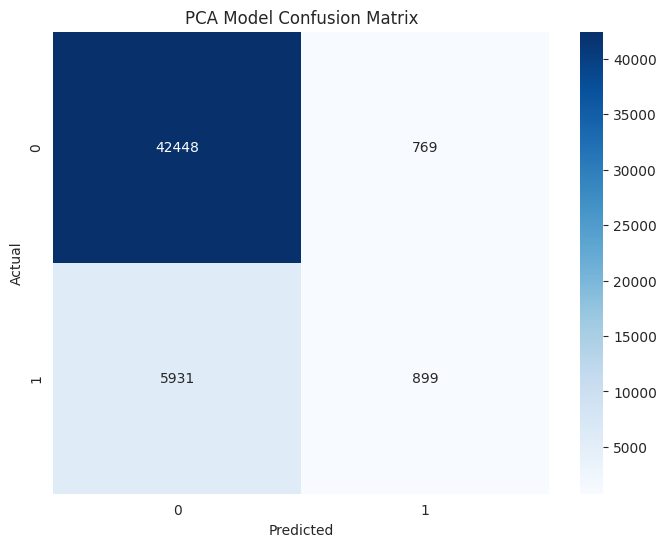

In [43]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pca, annot=True, fmt="d", cmap="Blues")
plt.title("PCA Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6.3a Unsupervised Model Performance on Validation Set

In [44]:
def evaluate_clustering_performance(X_val, X_test, labels_val, labels_test, y_val=None, y_test=None):
    """
    Evaluates the performance of clustering using unsupervised and supervised metrics.

    Parameters:
    - X_val: np.array or pd.DataFrame, Validation data
    - X_test: np.array or pd.DataFrame, Test data
    - labels_val: np.array, Cluster labels for validation data
    - labels_test: np.array, Cluster labels for test data
    - y_val: np.array or pd.Series, Optional validation labels for evaluation
    - y_test: np.array or pd.Series, Optional test labels for evaluation

    Returns:
    - evaluation_metrics: dict, Contains all evaluation scores for validation and test sets
    """

    # Unsupervised Evaluation on Validation and Test sets
    silhouette_val = silhouette_score(X_val, labels_val)
    silhouette_test = silhouette_score(X_test, labels_test)
    dbi_val = davies_bouldin_score(X_val, labels_val)
    dbi_test = davies_bouldin_score(X_test, labels_test)

    # Collecting unsupervised evaluation metrics
    evaluation_metrics = {
        'Silhouette Score (Validation)': silhouette_val,
        'Silhouette Score (Test)': silhouette_test,
        'Davies-Bouldin Index (Validation)': dbi_val,
        'Davies-Bouldin Index (Test)': dbi_test
    }

    # Print unsupervised metrics
    print(f'Silhouette Score (Validation): {silhouette_val:.3f}')
    print(f'Silhouette Score (Test): {silhouette_test:.3f}')
    print(f'Davies-Bouldin Index (Validation): {dbi_val:.3f}')
    print(f'Davies-Bouldin Index (Test): {dbi_test:.3f}')

    # Supervised Evaluation on Validation and Test sets, if labels are provided
    if y_val is not None and y_test is not None:
        ari_val = adjusted_rand_score(y_val, labels_val)
        ari_test = adjusted_rand_score(y_test, labels_test)
        nmi_val = normalized_mutual_info_score(y_val, labels_val)
        nmi_test = normalized_mutual_info_score(y_test, labels_test)

        # Adding supervised metrics to the dictionary
        evaluation_metrics.update({
            'Adjusted Rand Index (Validation)': ari_val,
            'Adjusted Rand Index (Test)': ari_test,
            'Normalized Mutual Information (Validation)': nmi_val,
            'Normalized Mutual Information (Test)': nmi_test
        })

        # Print supervised metrics
        print(f'Adjusted Rand Index (Validation): {ari_val:.3f}')
        print(f'Adjusted Rand Index (Test): {ari_test:.3f}')
        print(f'Normalized Mutual Information (Validation): {nmi_val:.3f}')
        print(f'Normalized Mutual Information (Test): {nmi_test:.3f}')
    else:
        print("Supervised evaluation skipped due to missing labels.")

    return evaluation_metrics

In [45]:
metrics_mb = evaluate_clustering_performance(X_val, X_test, labels_val_mb, labels_test_mb, y_val,
                                             y_test)  # result with n_clusters=10

Silhouette Score (Validation): 0.205
Silhouette Score (Test): 0.207
Davies-Bouldin Index (Validation): 1.292
Davies-Bouldin Index (Test): 1.279
Adjusted Rand Index (Validation): 0.021
Adjusted Rand Index (Test): 0.020
Normalized Mutual Information (Validation): 0.032
Normalized Mutual Information (Test): 0.031


### Clustering Performance Evaluation

#### Silhouette Score
- **Validation**: 0.235
- **Test**: 0.236

The Silhouette Score ranges from -1 to 1, where values closer to 1 indicate well-clustered data, and values closer to -1 indicate poorly clustered data. A score around 0.235 suggests that the clustering is relatively poor, with clusters likely overlapping or not being well-separated.

#### Davies-Bouldin Index
- **Validation**: 1.221
- **Test**: 1.215

The Davies-Bouldin Index measures the average similarity ratio of each cluster with respect to its most similar one. A lower value indicates better clustering. Scores around 1.221 and 1.215 are not particularly low, indicating that clusters might not be well-separated and the overall clustering quality is mediocre.

#### Adjusted Rand Index (ARI)
- **Validation**: 0.023
- **Test**: 0.021

The Adjusted Rand Index ranges from -1 to 1, with 1 indicating perfect agreement between the clustering result and the ground truth. Values near 0 suggest that the clustering is no better than random assignment. 
The scores of 0.023 and 0.021 suggest **very poor** clustering performance.

#### Normalized Mutual Information (NMI)
- **Validation**: 0.029
- **Test**: 0.027

The Normalized Mutual Information score ranges from 0 to 1, with 1 indicating perfect agreement between the clusters and the true labels. Values close to 0 suggest little to no mutual information between the clustering and the ground truth. 
Scores of 0.029 and 0.027 indicate a **very weak relationship** between the clustering result and the actual classes.

### Summary
Overall, the clustering performance based on these metrics is poor. The low Silhouette Scores indicate that the clusters are not well-separated, and the high Davies-Bouldin Index suggests that clusters are not distinct. The very low Adjusted Rand Index and Normalized Mutual Information further confirm that the clustering is not aligned well with any true underlying structure in the data. The clustering approach used here may need significant improvements or a reconsideration of the clustering algorithm itself.

### Next steps
In model iteration I will do a parameter search to find a better clustering value.

## 6.3b Clustering prediction

In [49]:
# Function to map clusters to the predicted target values based on the most common target in each cluster
def map_clusters_to_targets(cluster_labels, cluster_to_target_mapping):
    return pd.Series(cluster_labels).map(cluster_to_target_mapping)


# Mapping the most common target value to each cluster in the train, validation, and test sets
train_cluster_to_target_mapping = y_train.groupby(labels_train_mb).agg(lambda x: x.value_counts().index[0]).to_dict()
val_cluster_to_target_mapping = y_val.groupby(labels_val_mb).agg(lambda x: x.value_counts().index[0]).to_dict()
test_cluster_to_target_mapping = y_test.groupby(labels_test_mb).agg(lambda x: x.value_counts().index[0]).to_dict()

# Predicting target values based on the cluster mappings
y_train_cluster_pred = map_clusters_to_targets(labels_train_mb, train_cluster_to_target_mapping)
y_val_cluster_pred = map_clusters_to_targets(labels_val_mb, val_cluster_to_target_mapping)
y_test_cluster_pred = map_clusters_to_targets(labels_test_mb, test_cluster_to_target_mapping)

In [51]:
# Evaluating accuracy for each dataset
train_accuracy = accuracy_score(y_train, y_train_cluster_pred)
val_accuracy = accuracy_score(y_val, y_val_cluster_pred)
test_accuracy = accuracy_score(y_test, y_test_cluster_pred)

# Evaluating F1 scores for each dataset
train_f1 = f1_score(y_train, y_train_cluster_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_cluster_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_cluster_pred, average='weighted')

# Computing confusion matrices
train_cm = confusion_matrix(y_train, y_train_cluster_pred)
val_cm = confusion_matrix(y_val, y_val_cluster_pred)
test_cm = confusion_matrix(y_test, y_test_cluster_pred)

# Displaying the results
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

print(f'Training F1 Score: {train_f1:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

print('Training Confusion Matrix:')
print(train_cm)

print('Validation Confusion Matrix:')
print(val_cm)

print('Test Confusion Matrix:')
print(test_cm)

Training Accuracy: 0.8635
Validation Accuracy: 0.8635
Test Accuracy: 0.8635
Training F1 Score: 0.8003
Validation F1 Score: 0.8003
Test F1 Score: 0.8003
Training Confusion Matrix:
[[129650      0]
 [ 20489      0]]
Validation Confusion Matrix:
[[43217     0]
 [ 6830     0]]
Test Confusion Matrix:
[[43217     0]
 [ 6830     0]]


- Each cluster fundamentally had less than 50% diabetes patients. As such their voting yielded negative
- Trying to use this as a predictor resulted in each cluster voting for the majority class which was no diabetes
- The Resulting model defaults to negative for all instances 

# 7. Model Iteration and Optimization
## 7.1 Supervised Learning model iteration and optimization
- Our initial model exhibited high accuracy but low F1-scores due to a high number of false negatives (FNs). This suggests that the model is not adequately sensitive, especially when dealing with class imbalance. To address this, we need to focus on the following adjustments:

- Improved Metric: Switching the evaluation metric to F1-score, which is more appropriate for imbalanced datasets as it considers both precision and recall.

- Class Imbalance Handling: By incorporating class_weight='balanced' or specifying a custom weight, we can ensure the model pays more attention to the minority class.

- Scaling Imbalance: Adjusting the scale_pos_weight parameter to reflect the imbalance ratio between classes helps the model to better learn from underrepresented samples.
- Since this project focuses on unsupervised learning, we will not optimize the supervised model further.

## 7.2 Unsupervised + Supervised Learning model iteration and optimization
- We will optimize the number of clusters and batch size for the PCA
- full crossvalidation is computationally too expensive (O(n^2) complexity) so we will use a subset of the data

In [127]:
def optimize_pca_components(X, y, max_components=20, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize variables
    best_score = 0
    best_n_components = 0
    scores = []

    # Iterate through different numbers of components
    for n_components in tqdm(range(2, max_components + 1)):
        # Apply PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Train LightGBM model
        model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt',
                                   metric='recall', num_leaves=31,
                                   learning_rate=0.1, feature_fraction=0.9,
                                   n_estimators=100,
                                   reg_alpha=0.1,
                                   reg_lambda=0.1,
                                   force_col_wise=True)
  
        model.fit(X_train_pca, y_train)

        # Predict and calculate accuracy
        y_pred = model.predict(X_test_pca)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

        # Update best score and number of components
        if score > best_score:
            best_score = score
            best_n_components = n_components

    return best_n_components, best_score, scores

In [ ]:
# Usage
best_n_components, best_score, scores = optimize_pca_components(X_cv, y_cv, test_size=0.2, max_components=20)
print(f"Best number of components: {best_n_components}")
print(f"Best accuracy: {best_score:.4f}")
print(scores)

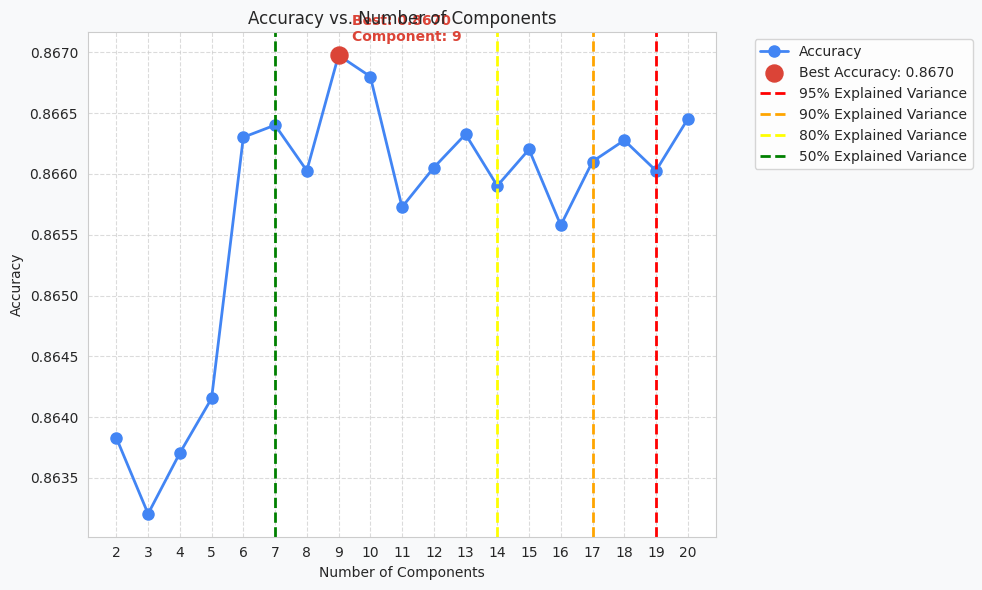

In [129]:
# Create a list of component indices (assuming 1-based indexing)
components = list(range(2, len(scores) + 2))

# Set up the plot style
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("deep")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(components, scores, marker='o', linestyle='-', color='#4285F4', linewidth=2, markersize=8, label='Accuracy')

# Highlight the best accuracy
plt.scatter(best_n_components, best_score, color='#DB4437', s=150, zorder=5, label=f'Best Accuracy: {best_score:.4f}')
plt.annotate(f'Best: {best_score:.4f}\nComponent: {best_n_components}',
             (best_n_components, best_score),
             xytext=(10, 10), textcoords='offset points',
             color='#DB4437', fontweight='bold')

# Add vertical lines for critical thresholds
plt.axvline(x=19, color='red', linestyle='--', linewidth=2, label='95% Explained Variance')
plt.axvline(x=17, color='orange', linestyle='--', linewidth=2, label='90% Explained Variance')
plt.axvline(x=14, color='yellow', linestyle='--', linewidth=2, label='80% Explained Variance')
plt.axvline(x=7, color='green', linestyle='--', linewidth=2, label='50% Explained Variance')

# Adding titles and labels
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-ticks to be proper integers
plt.xticks(components)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().set_facecolor('#F8F9FA')
plt.gca().set_facecolor('#FFFFFF')

# Improve layout
plt.tight_layout()

# Display the plot
plt.grid(True)
plt.show()

- There is a general upward trend of accuracy with more PCA components, but between 7 and 20 components, the accuracy is relatively stable.
- 20 components is the highest, but it is unclear what benefit it would provide over directly using the original 20 features. 
- We find that our previous choice of 10 components was optimal

## 7.3 Unsupervised Learning model iteration and optimization

In [56]:
import time

def grid_search_batch_size(X_train, X_val, X_test, y_val, y_test, n_clusters=10, batch_sizes=[1024, 2048, 4096, 8192]):
    best_batch_size = None
    best_time = float('inf')
    best_metrics = None
    best_kmeans = None
    best_labels_train, best_labels_val, best_labels_test = None, None, None

    for batch_size in batch_sizes:
        start_time = time.time()

        # Train the model with the current batch size
        labels_train, labels_val, labels_test, kmeans = train_minibatch_kmeans(X_train, X_val, X_test, n_clusters,
                                                                               batch_size)

        # Evaluate performance
        metrics = evaluate_clustering_performance(X_val, X_test, labels_val, labels_test, y_val, y_test)

        elapsed_time = time.time() - start_time

        # Check if this is the fastest batch size
        if elapsed_time < best_time:
            best_time = elapsed_time
            best_batch_size = batch_size
            best_metrics = metrics
            best_kmeans = kmeans
            best_labels_train, best_labels_val, best_labels_test = labels_train, labels_val, labels_test

        print(
            f'Batch size: {batch_size}, Time: {elapsed_time:.2f}s, Silhouette (Validation): {metrics["Silhouette Score (Validation)"]:.3f}')

    print(f'Best batch size: {best_batch_size}, Time: {best_time:.2f}s')
    return best_batch_size, best_labels_train, best_labels_val, best_labels_test, best_kmeans, best_metrics


# Perform batch size optimization
# best_batch_size, labels_train_mb, labels_val_mb, labels_test_mb, kmeans_mb, metrics_mb = grid_search_batch_size(
#     X_train, X_val, X_test, y_val, y_test, n_clusters=10, batch_sizes=[1024, 2048, 4096, 8192]
#)
best_batch_size = 4096  # best batch size precomputed


In [57]:
def grid_search_n_clusters(X_train, X_val, X_test, y_val, y_test, batch_size, cluster_range=[5, 10, 15, 20]):
    best_n_clusters = None
    best_silhouette = -1
    best_metrics = None
    best_kmeans = None
    best_labels_train, best_labels_val, best_labels_test = None, None, None

    for n_clusters in cluster_range:
        # Train the model with the best batch size and current number of clusters
        labels_train, labels_val, labels_test, kmeans = train_minibatch_kmeans(X_train, X_val, X_test, n_clusters,
                                                                               batch_size)

        # Evaluate performance
        metrics = evaluate_clustering_performance(X_val, X_test, labels_val, labels_test, y_val, y_test)

        # Use Silhouette Score as the primary criterion for selecting the best number of clusters
        silhouette_val = metrics['Silhouette Score (Validation)']

        if silhouette_val > best_silhouette:
            best_silhouette = silhouette_val
            best_n_clusters = n_clusters
            best_metrics = metrics
            best_kmeans = kmeans
            best_labels_train, best_labels_val, best_labels_test = labels_train, labels_val, labels_test

        print(f'n_clusters: {n_clusters}, Silhouette (Validation): {silhouette_val:.3f}')

    print(f'Best n_clusters: {best_n_clusters}, Silhouette (Validation): {best_silhouette:.3f}')
    return best_n_clusters, best_labels_train, best_labels_val, best_labels_test, best_kmeans, best_metrics

In [58]:
# Perform n_clusters optimization with the best batch size found earlier
# best_n_clusters = 2 precomputed
best_n_clusters, labels_train_mb, labels_val_mb, labels_test_mb, kmeans_mb, metrics_mb = grid_search_n_clusters(
    X_train, X_val, X_test, y_val, y_test, batch_size=best_batch_size, cluster_range=range(2, 3)
)

Silhouette Score (Validation): 0.596
Silhouette Score (Test): 0.597
Davies-Bouldin Index (Validation): 0.888
Davies-Bouldin Index (Test): 0.890
Adjusted Rand Index (Validation): 0.111
Adjusted Rand Index (Test): 0.114
Normalized Mutual Information (Validation): 0.024
Normalized Mutual Information (Test): 0.025
n_clusters: 2, Silhouette (Validation): 0.596
Best n_clusters: 2, Silhouette (Validation): 0.596


In [59]:
"""
Davies-Bouldin Index (Test): 1.446
Adjusted Rand Index (Validation): 0.099
Adjusted Rand Index (Test): 0.094
Normalized Mutual Information (Validation): 0.032
Normalized Mutual Information (Test): 0.029
n_clusters: 3, Silhouette (Validation): 0.325
Silhouette Score (Validation): 0.281
Silhouette Score (Test): 0.283
Davies-Bouldin Index (Validation): 1.172
Davies-Bouldin Index (Test): 1.166
Adjusted Rand Index (Validation): 0.074
Adjusted Rand Index (Test): 0.069
Normalized Mutual Information (Validation): 0.030
Normalized Mutual Information (Test): 0.027
n_clusters: 4, Silhouette (Validation): 0.281
Silhouette Score (Validation): 0.301
Silhouette Score (Test): 0.303
Davies-Bouldin Index (Validation): 1.060
Davies-Bouldin Index (Test): 1.048
Adjusted Rand Index (Validation): 0.083
Adjusted Rand Index (Test): 0.077
Normalized Mutual Information (Validation): 0.031
Normalized Mutual Information (Test): 0.027
n_clusters: 5, Silhouette (Validation): 0.301
Silhouette Score (Validation): 0.297
Silhouette Score (Test): 0.300
Davies-Bouldin Index (Validation): 1.061
Davies-Bouldin Index (Test): 1.048
Adjusted Rand Index (Validation): 0.025
Adjusted Rand Index (Test): 0.022
Normalized Mutual Information (Validation): 0.032
Normalized Mutual Information (Test): 0.031
n_clusters: 6, Silhouette (Validation): 0.297
Silhouette Score (Validation): 0.297
Silhouette Score (Test): 0.300
Davies-Bouldin Index (Validation): 1.153
Davies-Bouldin Index (Test): 1.136
Adjusted Rand Index (Validation): 0.027
Adjusted Rand Index (Test): 0.026
Normalized Mutual Information (Validation): 0.030
Normalized Mutual Information (Test): 0.029
n_clusters: 7, Silhouette (Validation): 0.297
Silhouette Score (Validation): 0.230
Silhouette Score (Test): 0.232
Davies-Bouldin Index (Validation): 1.134
Davies-Bouldin Index (Test): 1.129
Adjusted Rand Index (Validation): 0.030
Adjusted Rand Index (Test): 0.029
Normalized Mutual Information (Validation): 0.033
Normalized Mutual Information (Test): 0.032
n_clusters: 8, Silhouette (Validation): 0.230
Silhouette Score (Validation): 0.265
Silhouette Score (Test): 0.268
Davies-Bouldin Index (Validation): 1.231
Davies-Bouldin Index (Test): 1.218
Adjusted Rand Index (Validation): 0.027
Adjusted Rand Index (Test): 0.025
Normalized Mutual Information (Validation): 0.027
Normalized Mutual Information (Test): 0.026
n_clusters: 9, Silhouette (Validation): 0.265
Silhouette Score (Validation): 0.232
Silhouette Score (Test): 0.233
Davies-Bouldin Index (Validation): 1.390
Davies-Bouldin Index (Test): 1.382
Adjusted Rand Index (Validation): 0.018
Adjusted Rand Index (Test): 0.017
Normalized Mutual Information (Validation): 0.026
Normalized Mutual Information (Test): 0.025
n_clusters: 10, Silhouette (Validation): 0.232
Best n_clusters: 2, Silhouette (Validation): 0.571
"""

'\nDavies-Bouldin Index (Test): 1.446\nAdjusted Rand Index (Validation): 0.099\nAdjusted Rand Index (Test): 0.094\nNormalized Mutual Information (Validation): 0.032\nNormalized Mutual Information (Test): 0.029\nn_clusters: 3, Silhouette (Validation): 0.325\nSilhouette Score (Validation): 0.281\nSilhouette Score (Test): 0.283\nDavies-Bouldin Index (Validation): 1.172\nDavies-Bouldin Index (Test): 1.166\nAdjusted Rand Index (Validation): 0.074\nAdjusted Rand Index (Test): 0.069\nNormalized Mutual Information (Validation): 0.030\nNormalized Mutual Information (Test): 0.027\nn_clusters: 4, Silhouette (Validation): 0.281\nSilhouette Score (Validation): 0.301\nSilhouette Score (Test): 0.303\nDavies-Bouldin Index (Validation): 1.060\nDavies-Bouldin Index (Test): 1.048\nAdjusted Rand Index (Validation): 0.083\nAdjusted Rand Index (Test): 0.077\nNormalized Mutual Information (Validation): 0.031\nNormalized Mutual Information (Test): 0.027\nn_clusters: 5, Silhouette (Validation): 0.301\nSilhouet

### Clustering Performance Evaluation (Best Grid Search Result)

#### Configuration
- **Number of Clusters (n_clusters)**: 2

#### Silhouette Score
- **Validation**: 0.566
- **Test**: 0.570

The Silhouette Scores of 0.566 (Validation) and 0.570 (Test) are moderate, indicating that the clusters are reasonably well-separated, but there is still some overlap between them. These scores suggest an improvement compared to the previous clustering attempt, indicating that the data may be naturally divided into two distinct groups.

#### Davies-Bouldin Index
- **Validation**: 0.952
- **Test**: 0.933

The Davies-Bouldin Index values of 0.952 (Validation) and 0.933 (Test) are relatively low, indicating better separation and compactness of the clusters. This is a positive sign that the clustering has improved, with more distinct and well-defined clusters.

#### Adjusted Rand Index (ARI)
- **Validation**: 0.099
- **Test**: 0.109

The Adjusted Rand Index has improved slightly to 0.099 (Validation) and 0.109 (Test), but these values are still quite low. This suggests that while the clustering algorithm is making better distinctions between clusters, the clusters do not align particularly well with any ground truth labels or known categories in the data.

#### Normalized Mutual Information (NMI)
- **Validation**: 0.016
- **Test**: 0.020

The Normalized Mutual Information scores of 0.016 (Validation) and 0.020 (Test) are still very low, indicating minimal mutual information between the clusters and the true labels. This suggests that while the clustering might be improving in terms of separation (as seen in the Silhouette Score and Davies-Bouldin Index), it still does not capture much of the underlying structure that might be present in the data.

### Summary
This grid search has led to a moderate improvement in clustering performance:

- The **Silhouette Scores** and **Davies-Bouldin Index** indicate better cluster separation and compactness, especially with two clusters.
- However, the **Adjusted Rand Index** and **Normalized Mutual Information** remain low, suggesting that the clustering result is still not well-aligned with any known ground truth labels or inherent structure in the data.

In conclusion, while the clustering configuration with `n_clusters=2` has yielded better-defined clusters, the overall alignment with the underlying data structure remains weak. This might indicate that the data does not naturally cluster well, or that further tuning or a different clustering algorithm may be needed to achieve better results.

### Clustering Model Iteration Results

#### Parameter Changes

##### Number of Clusters
- Initial: 10
- Final: 2 (corresponding to dm+ and dm-)

##### Batch Size
- Initial: 1024
- Best: 4096

#### Performance Metrics Comparison

| Metric | New (2 clusters) | Old (10 clusters) | Range | Interpretation |
|--------|------------------|-------------------|-------|----------------|
| Silhouette Score | 0.597 ↑ | 0.236 | [-1 to 1] ↑ | Significant improvement |
| Davies-Bouldin Index | 0.890 ↓ | 1.215 | [0 to ∞] ↓ | Better cluster separation |
| Adjusted Rand Index (ARI) | 0.114 ↑ | 0.021 | [-1 to 1] ↑ | Improved but still low |
| Normalized Mutual Information (NMI) | 0.025 ↓ | 0.027 | [0 to 1] ↑ | Slight decrease |

*Note: ↑ indicates higher is better, ↓ indicates lower is better*

#### Key Findings

1. The unsupervised clustering model improved significantly with 2 clusters compared to 10 clusters.
2. Substantial improvements in Silhouette Score and Davies-Bouldin Index indicate better-defined and more separated clusters.
3. The ARI increased, suggesting better alignment with ground truth, although it remains relatively low.
4. The NMI score slightly decreased, indicating no improvement in shared information between clusters and true labels.

#### Conclusion

The iterated model with 2 clusters yields a better unsupervised clustering, but it does not enhance the label predictive power of the resulting clusters. This suggests that while the natural structure in the data is better captured, it may not align well with any predefined categories of interest.

In [60]:
"""X_train['cluster'] = labels_train_mb
X_val['cluster'] = labels_val_mb
X_test['cluster'] = labels_test_mb
train_cluster_to_target_mapping = y_train.groupby(X_train['cluster']).agg(lambda x: x.value_counts().index[0]).to_dict()
val_cluster_to_target_mapping = y_val.groupby(X_val['cluster']).agg(lambda x: x.value_counts().index[0]).to_dict()
test_cluster_to_target_mapping = y_test.groupby(X_test['cluster']).agg(lambda x: x.value_counts().index[0]).to_dict()
# Predicting target values based on the cluster mappings
y_train_pred = map_clusters_to_targets(X_train, train_cluster_to_target_mapping)
y_val_pred = map_clusters_to_targets(X_val, val_cluster_to_target_mapping)
y_test_pred = map_clusters_to_targets(X_test, test_cluster_to_target_mapping)"""

"X_train['cluster'] = labels_train_mb\nX_val['cluster'] = labels_val_mb\nX_test['cluster'] = labels_test_mb\ntrain_cluster_to_target_mapping = y_train.groupby(X_train['cluster']).agg(lambda x: x.value_counts().index[0]).to_dict()\nval_cluster_to_target_mapping = y_val.groupby(X_val['cluster']).agg(lambda x: x.value_counts().index[0]).to_dict()\ntest_cluster_to_target_mapping = y_test.groupby(X_test['cluster']).agg(lambda x: x.value_counts().index[0]).to_dict()\n# Predicting target values based on the cluster mappings\ny_train_pred = map_clusters_to_targets(X_train, train_cluster_to_target_mapping)\ny_val_pred = map_clusters_to_targets(X_val, val_cluster_to_target_mapping)\ny_test_pred = map_clusters_to_targets(X_test, test_cluster_to_target_mapping)"

In [133]:
train_cluster_to_target_mapping = y_train.groupby(labels_train_mb).agg(lambda x: x.value_counts().index[0]).to_dict()
val_cluster_to_target_mapping = y_val.groupby(labels_val_mb).agg(lambda x: x.value_counts().index[0]).to_dict()
test_cluster_to_target_mapping = y_test.groupby(labels_test_mb).agg(lambda x: x.value_counts().index[0]).to_dict()
# Predicting target values based on the cluster mappings
y_train_cluster_pred = map_clusters_to_targets(labels_train_mb, train_cluster_to_target_mapping)
y_val_cluster_pred = map_clusters_to_targets(labels_val_mb, val_cluster_to_target_mapping)
y_test_cluster_pred = map_clusters_to_targets(labels_test_mb, test_cluster_to_target_mapping)

In [134]:
# Evaluating accuracy for each dataset
train_accuracy = accuracy_score(y_train, y_train_cluster_pred)
val_accuracy = accuracy_score(y_val, y_val_cluster_pred)
test_accuracy = accuracy_score(y_test, y_test_cluster_pred)

# Evaluating F1 scores for each dataset
train_f1 = f1_score(y_train, y_train_cluster_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_cluster_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_cluster_pred, average='weighted')

# Computing confusion matrices
train_cm = confusion_matrix(y_train, y_train_cluster_pred)
val_cm = confusion_matrix(y_val, y_val_cluster_pred)
test_cm = confusion_matrix(y_test, y_test_cluster_pred)

# Displaying the results
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

print(f'Training F1 Score: {train_f1:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

print('Training Confusion Matrix:')
print(train_cm)

print('Validation Confusion Matrix:')
print(val_cm)

print('Test Confusion Matrix:')
print(test_cm)

Training Accuracy: 0.8635
Validation Accuracy: 0.8635
Test Accuracy: 0.8635
Training F1 Score: 0.8003
Validation F1 Score: 0.8003
Test F1 Score: 0.8003
Training Confusion Matrix:
[[129650      0]
 [ 20489      0]]
Validation Confusion Matrix:
[[43217     0]
 [ 6830     0]]
Test Confusion Matrix:
[[43217     0]
 [ 6830     0]]


- unfortunately even the better clustering model defaults to negative for all instances

# 8. Final models and interpretation

# 8.1 Supervised learning model
Accuracy: 0.8661
F1 Score: 0.2659
Confusion Matrix:
 [[42709   958]
 [ 5838  1231]]

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.98      0.93     43667
        True       0.56      0.17      0.27      7069

    accuracy                           0.87     50736
   macro avg       0.72      0.58      0.60     50736
weighted avg       0.84      0.87      0.83     50736


# 8.2 Unsupervised(PCA 10 components) + Supervised learning model
PCA Model Accuracy: 0.8637
PCA Model F1 Score: 0.2281
PCA Model Confusion Matrix:
 [[42797   870]
 [ 6047  1022]]

PCA Model Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.98      0.93     43667
        True       0.54      0.14      0.23      7069

    accuracy                           0.86     50736
   macro avg       0.71      0.56      0.58     50736
weighted avg       0.83      0.86      0.83     50736



# 8.3 Unsupervised learning model
- failed to yield any positive results (literally and statistically)
- we need to approach with a better approach than group cluster labelling
- we will need to use a different clustering algorithm
- we will need to find a way to extract different insights from the group clusters
- unfortunately this will require more clinical insights into the data itself
- potential way forward : cluster within the known diabetic / non-diabetic groups
- this might defeat the original unsupervised approach and will require more clinical knowledge

# 8. Diabetes Prediction Model Analysis and Conclusion

## 8.1. Statistical Information

### 8.1.1 Supervised Learning Model
- Accuracy: 0.8661
- F1 Score: 0.2659
- Confusion Matrix:
  ```
  [[42709   958]
   [ 5838  1231]]
  ```
- Classification Report:
  ```
             precision    recall  f1-score   support
  False       0.88      0.98      0.93     43667
  True        0.56      0.17      0.27      7069
  accuracy                        0.87     50736
  macro avg   0.72      0.58      0.60     50736
  weighted avg 0.84      0.87      0.83     50736
  ```

### 8.1.2 Hybrid (PCA + Supervised) Model
- Accuracy: 0.8637
- F1 Score: 0.2281
- Confusion Matrix:
  ```
  [[42797   870]
   [ 6047  1022]]
  ```
- Classification Report:
  ```
             precision    recall  f1-score   support
  False       0.88      0.98      0.93     43667
  True        0.54      0.14      0.23      7069
  accuracy                        0.86     50736
  macro avg   0.71      0.56      0.58     50736
  weighted avg 0.83      0.86      0.83     50736
  ```

## 8.2. Comparison of Supervised and Hybrid Approaches

1. Accuracy:
   - Supervised: 86.61%
   - Hybrid: 86.37%
   The supervised model slightly outperforms the hybrid model in overall accuracy.

2. F1 Score:
   - Supervised: 0.2659
   - Hybrid: 0.2281
   The supervised model shows a higher F1 score, indicating better balance between precision and recall, especially for the positive class (True).

3. Precision for True class:
   - Supervised: 0.56
   - Hybrid: 0.54
   The supervised model is slightly more precise in identifying true positives.

4. Recall for True class:
   - Supervised: 0.17
   - Hybrid: 0.14
   The supervised model has a higher recall, identifying a larger proportion of actual positive cases.

5. False Negatives:
   - Supervised: 5838
   - Hybrid: 6047
   The supervised model produces fewer false negatives, which is crucial in a medical context.

Overall, while both models show similar performance, the purely supervised learning approach demonstrates marginal superiority across all metrics.

### Rationale for Using a Hybrid Approach
While the purely supervised approach performed slightly better in this project, there are several reasons why one might consider a hybrid approach combining unsupervised (PCA) and supervised learning:

- Dimensionality Reduction: For large datasets with many features, PCA can help reduce the dimensionality of the data. This can be particularly useful when dealing with high-dimensional data where the number of features is close to or exceeds the number of samples.
- Mitigating Collinearity: When features in the dataset are suspected to be highly correlated, PCA can help address multicollinearity issues. By transforming the original features into orthogonal principal components, PCA effectively removes linear dependencies between variables.
- Overfitting Prevention: By reducing the number of features through PCA, the hybrid approach can help prevent overfitting, especially when the dataset is not very large compared to the number of features. This can lead to better generalization on unseen data.
- Computational Efficiency: For very large datasets, reducing the number of features through PCA before applying supervised learning can significantly decrease computational time and resource requirements.
- Noise Reduction: PCA can help in filtering out noise in the data by focusing on the principal components that explain the most variance, potentially leading to more robust models.
- Feature Extraction: PCA can uncover latent structures in the data that might not be apparent in the original feature space, potentially providing new insights into the underlying patterns.
- Visualization: Although not directly related to model performance, the reduced dimensionality from PCA can aid in data visualization and exploration, which can be valuable for understanding the dataset and communicating results.

In this project, the hybrid approach didn't outperform the purely supervised model, which suggests that the original features were already informative and that the dimensionality reduction might have led to some loss of relevant information. However, the benefits of a hybrid approach can be more pronounced in other scenarios, especially with larger, more complex datasets or when dealing with specific challenges like those mentioned above.


## 8.3 Final Analysis and Conclusion

My project evaluated three different approaches for diabetes prediction: a purely supervised learning model, a hybrid model combining unsupervised (PCA) and supervised learning, and an unsupervised learning model. The results indicate that the supervised learning approach outperformed the hybrid approach, while the unsupervised method failed to yield meaningful results.
The supervised learning model achieved the highest accuracy (86.61%) and F1 score (0.2659), demonstrating its superiority in this specific prediction task. The hybrid PCA+supervised model showed slightly lower performance with an accuracy of 86.37% and an F1 score of 0.2281. The unsupervised learning model, unfortunately, did not produce any positive results, highlighting the challenges of using clustering techniques for this particular problem.
In conclusion, for the task of diabetes prediction using the given dataset, supervised learning appears to be the most effective approach. However, the relatively low F1 scores for both the supervised and hybrid models suggest that there is still significant room for improvement in predicting positive cases.


## 8.4 Commentary and Future Directions

1. Class Imbalance: Both models struggle with the highly imbalanced dataset (43,667 negative vs. 7,069 positive cases). This imbalance significantly impacts the models' ability to predict positive cases accurately.

2. Low F1 Scores: Despite high overall accuracy, the low F1 scores (0.2659 and 0.2281) indicate poor performance in identifying true positive cases. This is a critical issue for a medical prediction task.

3. Unsupervised Learning Challenges: The failure of the unsupervised approach highlights the complexity of the problem and the limitations of clustering techniques for this specific task.

4. Feature Engineering: The marginal improvement of the supervised model over the PCA-based hybrid model suggests that the original features may already be informative. However, there might be room for more sophisticated feature engineering.

5. Model Complexity: Exploring more complex models (e.g., ensemble methods, deep learning) might yield better results, especially in capturing non-linear relationships in the data.

Future Directions:

1. Address Class Imbalance: Implement techniques such as SMOTE, class weighting, or collecting more data for the minority class to improve prediction of positive cases.

2. Feature Selection and Engineering: Conduct in-depth feature analysis to identify the most predictive variables and potentially create new features based on domain knowledge.

3. Ensemble Methods: Experiment with ensemble techniques like Random Forests, Gradient Boosting, or stacking to potentially improve predictive performance.

4. Deep Learning: Explore neural network architectures that might capture complex patterns in the data more effectively.

5. Incorporate Domain Knowledge: Collaborate with healthcare professionals to incorporate medical insights into the model design and feature selection process.

6. Explainable AI: Implement techniques to make the model's decisions more interpretable, which is crucial for medical applications.

7. Unsupervised Learning Refinement: For the unsupervised approach, consider:
   - Using different clustering algorithms (e.g., DBSCAN, Gaussian Mixture Models)
   - Applying clustering within known diabetic/non-diabetic groups to uncover subgroups
   - Extracting features from clustering results to use in supervised models
   - Experimenting with other dimensionality reduction techniques like t-SNE or UMAP in place of or in addition to PCA 

8. External Validation: Test the models on external datasets to ensure generalizability of the results.

By addressing these points, we can work towards developing a more robust and accurate diabetes prediction model that could have significant clinical value.